# 0.0 IMPORTS

In [3]:
import math
import inflection
import datetime
import tabulate
import random
import pickle
import numpy    as np
import pandas   as pd
import scipy    as ss
import seaborn  as sns
import xgboost as xgb

from matplotlib             import pyplot as plt
from IPython.core.display   import HTML
from IPython.display        import Image
from tabulate               import tabulate
from scipy                  import stats
from boruta                 import BorutaPy
from sklearn.preprocessing  import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble       import RandomForestRegressor
from sklearn.metrics        import mean_absolute_error, mean_squared_error
from sklearn.linear_model   import LinearRegression, Lasso

## 0.1 Helper Functions - VERIFICAR V DE CRAMÉR

In [2]:
#V de Cramér - Cálculo de relação entre variáveis categóricas
# Varia de 0 até 1, quanto mais perto de 1, mis forte a corelação das variáveis analisadas.
# Cálculo:
    # cm = pd.crosstab(a['state_holiday'], a['store_type']).to_numpy()
    # chi2 = ss.stats.chi2_contingency(cm)[0]
    # n = cm.sum()
    # r, k = cm.shape
    # v = np.sqrt((chi2/n) / (min(k-1, r-1)))
    
# V de Cramér em formato de função com a correção de bias:
def cramer_v( x, y ):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
      
    chi2 = ss.stats.chi2_contingency( cm )[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(r-1)
    
    return np.sqrt( (chi2/n) / (min(k-1, r-1) ) )

def jupyter_settings():
     %matplotlib inline
     %pylab inline
     plt.style.use( 'bmh' )
     plt.rcParams['figure.figsize'] = [25, 18]
     plt.rcParams['font.size'] = 32
     display( HTML( '<style>.container { width:100% !important; }</style>') )
     pd.options.display.max_columns = None
     pd.options.display.max_rows = None
     pd.set_option( 'display.expand_frame_repr', False )
     sns.set()

def mean_absolute_percent_error (y, yhat) :
    return np.mean (np.abs((y - yhat) / y))

def mean_percentage_error (y, yhat) :
    return np.mean( (y - yhat) / y )

def ml_error (model_name, y, yhat) :
    mae = mean_absolute_error (y, yhat)
    mape = mean_absolute_percent_error (y, yhat)
    rmse = np.sqrt(mean_squared_error (y, yhat))
    
    return pd.DataFrame ({ 'Model Name' : model_name,
                           'MAE' : mae,   
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0])

def cross_validation (x_training, kfold, model_name, model, verbose = False) :
    # Listas para armazenar os resultados
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range (1, 6)) :
        if verbose :
            print ( '\nKfold number: {}' .format( k ))
        # 1ª data da validação (último dia de vendas menos 6 semanas)
        validation_start_date = x_training['date'].max() - datetime.timedelta( days = k*6*7 )
        # última data da validação (primeiro dia de vendas)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days = (k-1)*6*7 )

        # Filtrar do DataSet
        # Dados de treinamento - são todos que possuem data anterior a 1ª data de validação 
        training = x_training[x_training['date'] < validation_start_date]
        # Dados de validação - são todas as datas que então entre a 1ª e a última data de validação 
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # Training and validation DataSets (retirar as colunas Date e Sales, elas não podem estar no treinamento)
        xtraining = training.drop( ['date', 'sales'], axis = 1)
        ytraining = training['sales']

        xvalidation = validation.drop( ['date', 'sales'], axis = 1)
        yvalidation = validation['sales']


        #model
        m = model.fit(xtraining, ytraining)

        #prediction
        yhat = m.predict (xvalidation)

        #performance
        m_result = ml_error (model_name, np.expm1(yvalidation), np.expm1(yhat))

        # Guarda o resultado de iteração do Kfold nas listas
        mae_list.append ( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame ({'Model Name' : model_name,
                          'MAE CV' : np.round(np.mean(mae_list), 2).astype(str) + '+/-' + np.round (np.std(mae_list), 2).astype(str),
                          'MAPE CV' : np.round(np.mean(mape_list), 2).astype(str) + '+/-' + np.round (np.std(mape_list), 2).astype(str),
                          'RMSE CV' : np.round(np.mean(rmse_list), 2).astype(str) + '+/-' + np.round (np.std(rmse_list), 2).astype(str)}, index = [0])

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


/home/eron/.pyenv/versions/3.9.4/envs/RossmannProject/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2 Loading Data

In [4]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False )
df_store_raw = pd.read_csv('data/store.csv', low_memory=False )

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store' )

In [5]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
106027,103,1,2015-04-27,5880,501,1,1,0,0,d,c,5210.0,5.0,2015.0,0,NaN,NaN,NaN


# 1.0. DESCRICAO DOS DADOS

In [6]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore (x)

cols_new = list( map( snakecase, cols_old ))

#rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [8]:
print( 'Number of Rows: {}' .format(df1.shape[0]))
print( 'Number of Columns: {}' .format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


## 1.3. Data Types

In [9]:
df1['date'] = pd.to_datetime(df1['date'])

In [10]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA 

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [12]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Set', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

In [13]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types 

In [14]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7. Descriptive Statistical 

In [15]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [16]:
# Central Tendence - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = (['attribuites', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])
m

,attribuites,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2. Categorical Attributes

In [17]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

Populating the interactive namespace from numpy and matplotlib


<AxesSubplot:xlabel='assortment', ylabel='sales'>

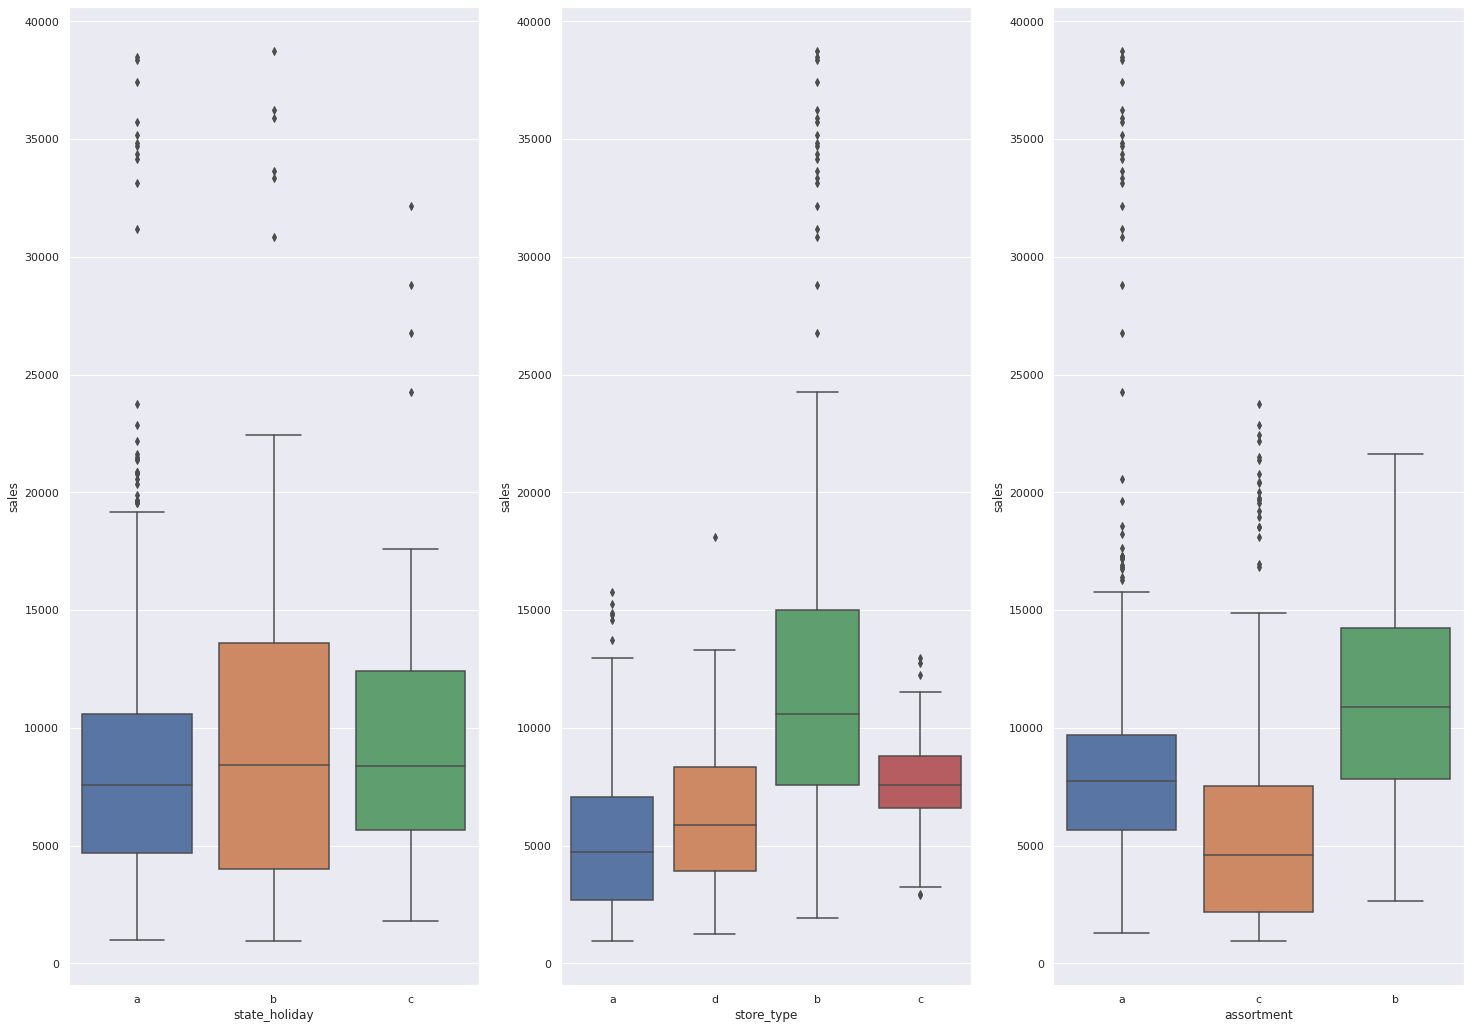

In [18]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

#fig = plt.figure(figsize=(18,8), facecolor='#D1D1D1')
jupyter_settings()

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday' , y='sales' , data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type' , y='sales' , data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment' , y='sales' , data=aux1)

# 2.0. FEATURE ENGINEERING

In [19]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipóteses

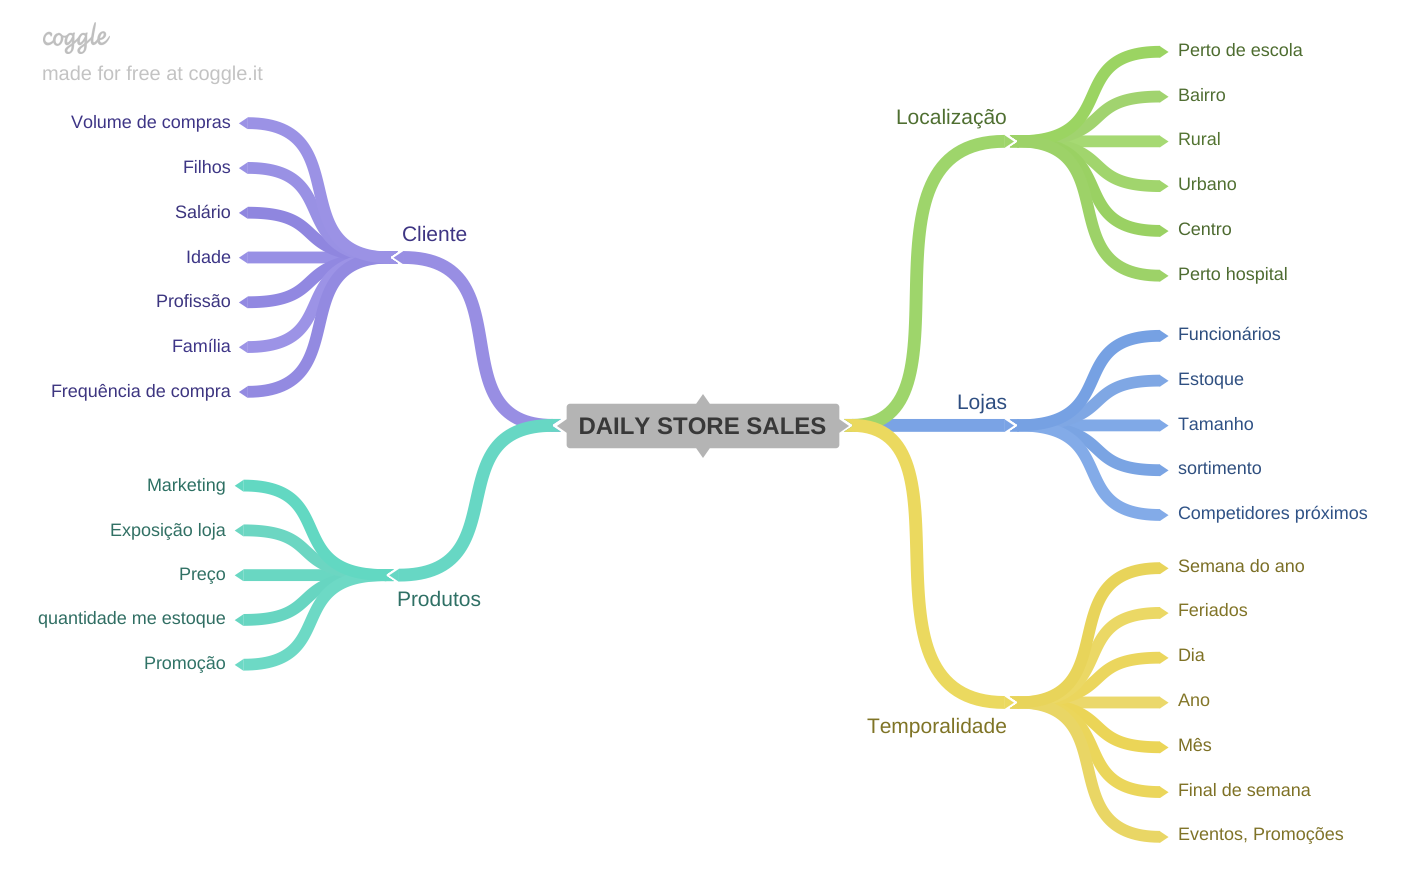

In [20]:
Image('img/MindMapHypothesis.png')

## 2.2. Criação de Hipóteses

### 2.2.1 Hipóteses Loja

**1.** Lojas com maior número de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento de produto deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores há mais tempo deveriam vender mais.

### 2.2.2. Hipóteses Produtos

**1.** Lojas que investem mais em margeting deveriam vender mais.

**2.** Lojas com maior exposição do produto deveriam vender mais.

**3.** Lojas com produtos de menor preço deveriam vender mais.

**4.** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3. Hipóteses Temporais

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Lista final de hipóteses

**1.** Lojas com maior sortimento de produto deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores há mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

In [21]:
df2.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9,2008,0,31,2015,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9,2009,0,31,2015,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4,2015,0,31,2015,0,Jul,0


In [22]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 2.4. Feature Engineering

In [23]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


# competition since
df2['competition_since'] = df2.apply (lambda x: datetime.datetime (year = x['competition_open_since_year'], month = x['competition_open_since_month'] , day = 1), axis = 1)
df2['competition_time'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta( days = 7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'Christmas' if x == 'c' else 'regular_day')

In [24]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. FILTRAGEM DE VARIÁVEIS

In [25]:
df3 = df2.copy()

In [26]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Filtragem das linhas

In [27]:
# Para haver vendas a loja precisa estar aberta
# Só interessam as vendas maiores que 0, quando for 0 a loja estava fechada
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Seleção das colunas

In [28]:
# CUSTOMERS - Não há como saber quantos consumidores estarão na loja nos dias das 6 semanas de predição de vendas
# OPEN - Após a filtragem das linhas feita acima, a coluna open passou a ter apenas valores 1, assim não há variação e informação relevante.
# PROMO_INTERVAL - Foi derivada e resultou a coluna IS_PROMO, seu conteúdo não é mais relevante.
# MONTH_MAP - coluna auxiliar usada para a criação das datas, neste momento já não tem mais utilidade.

cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [29]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. ANÁLISE EXPLORATÓRIA DOS DADOS

In [30]:
df4 = df3.copy()

## 4.1. Análise Univariada

### 4.1.1. Response Variable

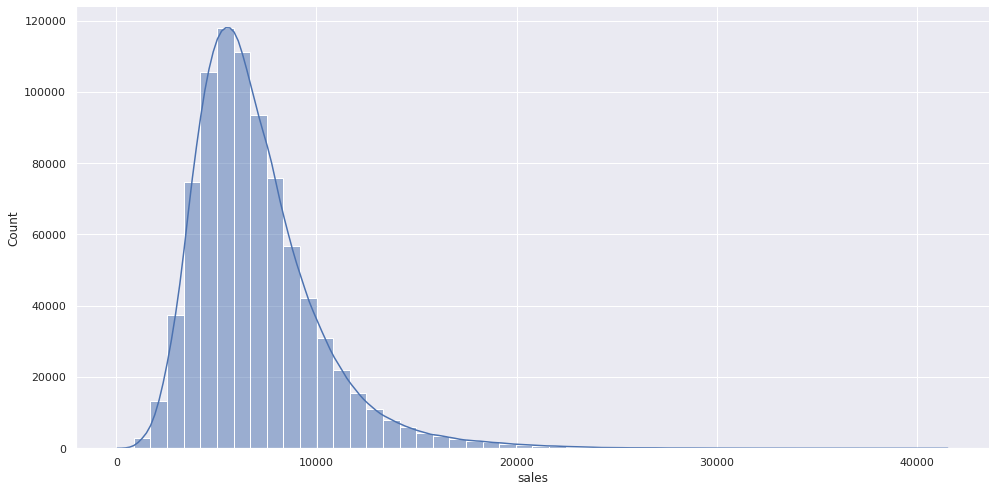

In [31]:
sns.displot(df4['sales'], kind='hist', height=7, aspect=2, bins=50, kde=True)

### 4.1.2. Numerical Variable

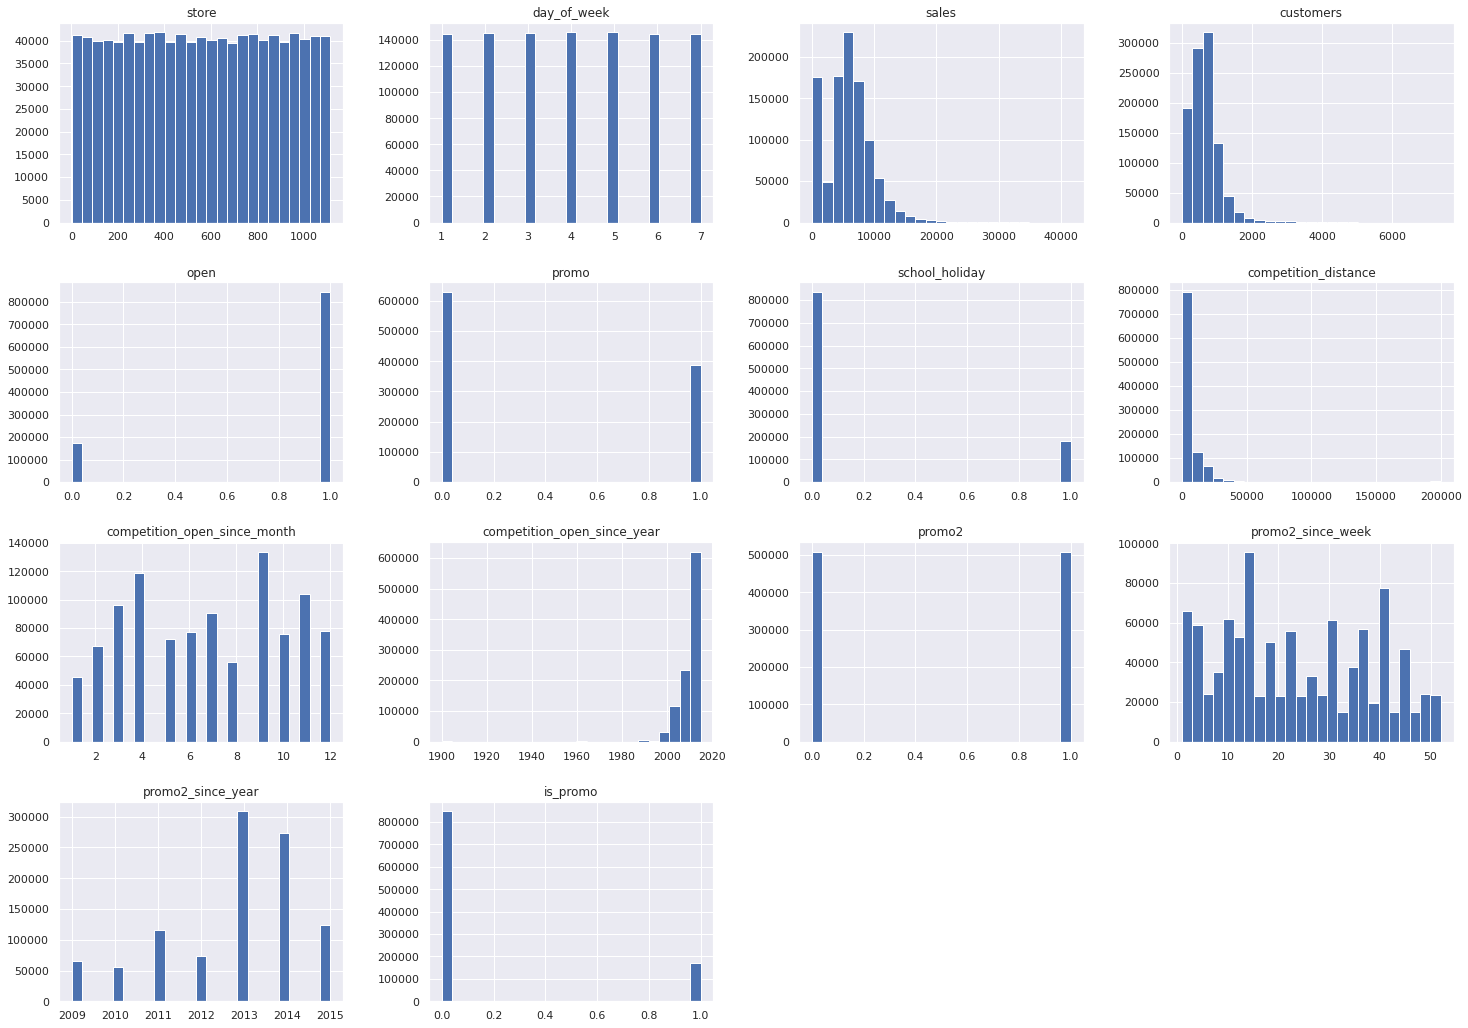

In [32]:
num_attributes.hist(bins = 25);

### 4.1.3 Categorical Variable

/home/eron/.pyenv/versions/3.9.4/envs/RossmannProject/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/eron/.pyenv/versions/3.9.4/envs/RossmannProject/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/eron/.pyenv/versions/3.9.4/envs/RossmannProject/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments witho

<AxesSubplot:xlabel='sales', ylabel='Density'>

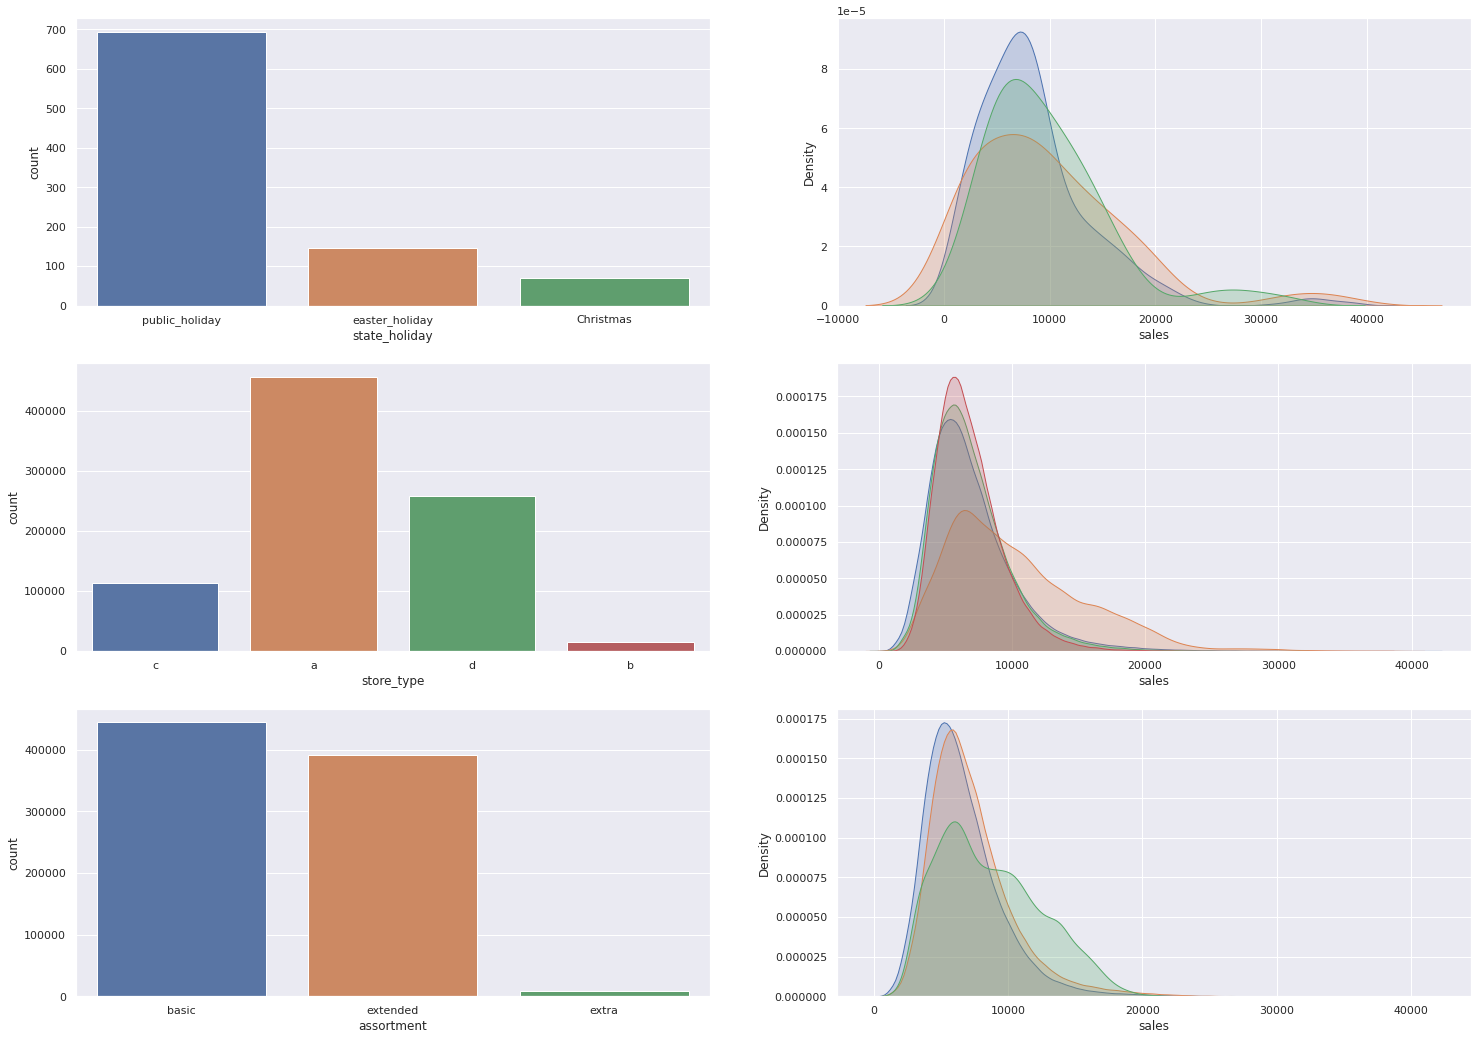

In [33]:
# state_holiday
plt.subplot (3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot (3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'Christmas']['sales'], label='Christmas', shade = True)

# store_type
plt.subplot (3, 2, 3)
sns.countplot(df4['store_type'])

plt.subplot (3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade = True)

# assortment
plt.subplot (3, 2, 5)
sns.countplot(df4['assortment'])

plt.subplot (3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade = True)

## 4.2. Análise Bivariada

### H1. Lojas com maior sortimento de produto deveriam vender mais.

**FALSA** - Loja com **MAIOR SORTIMENTO** (assortment) vendem **MENOS**

<AxesSubplot:xlabel='year_week'>

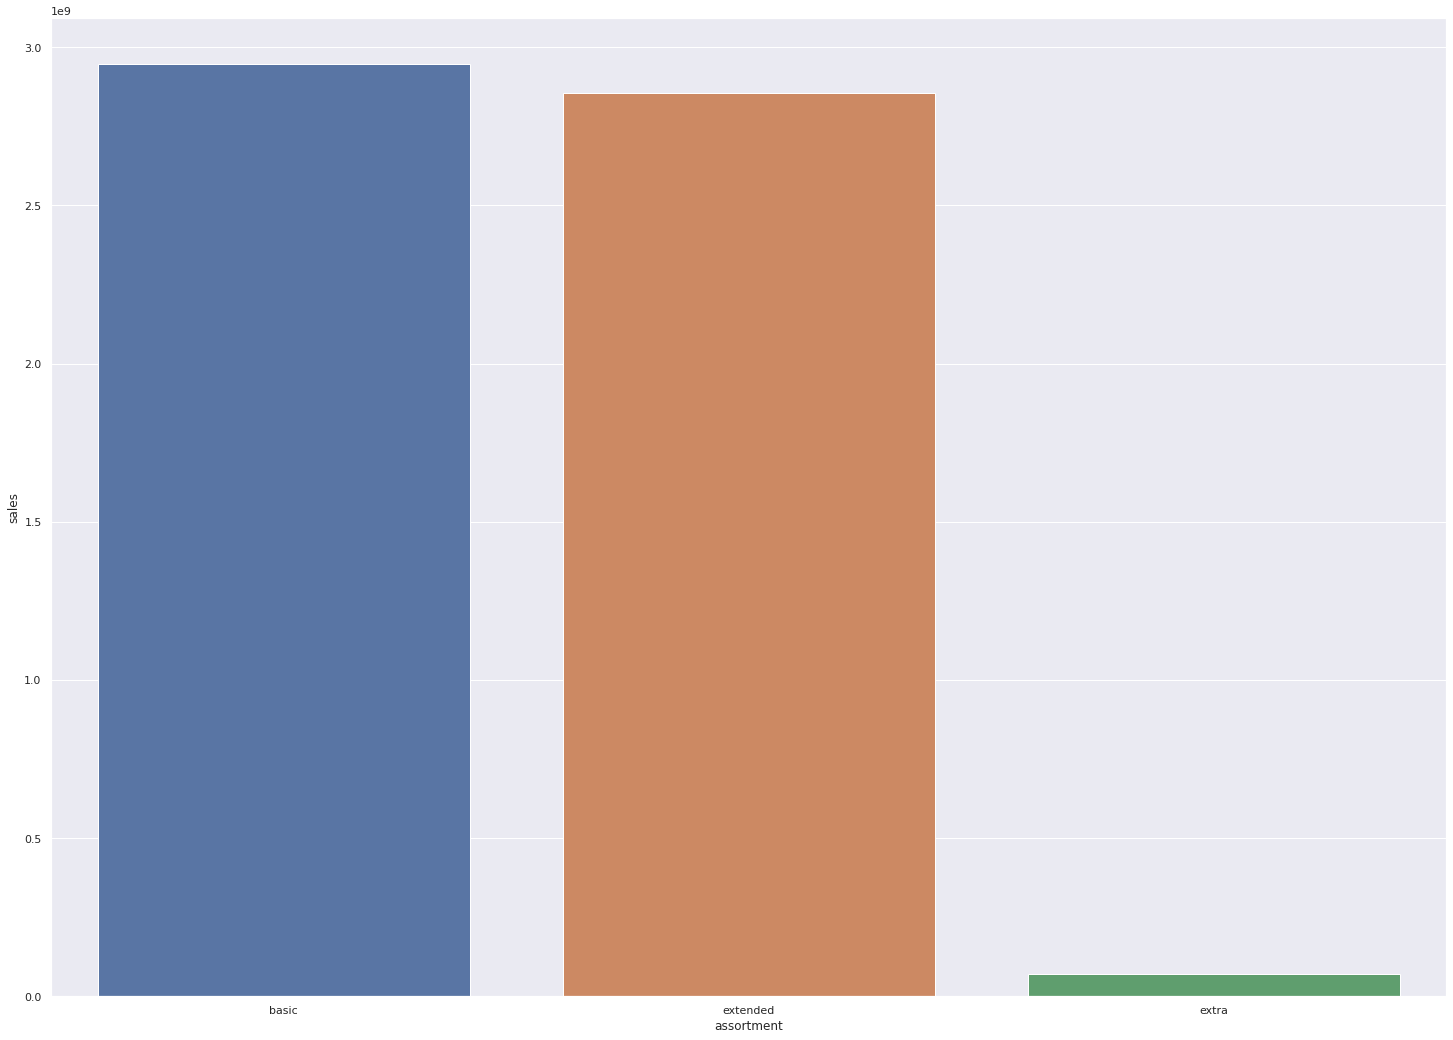

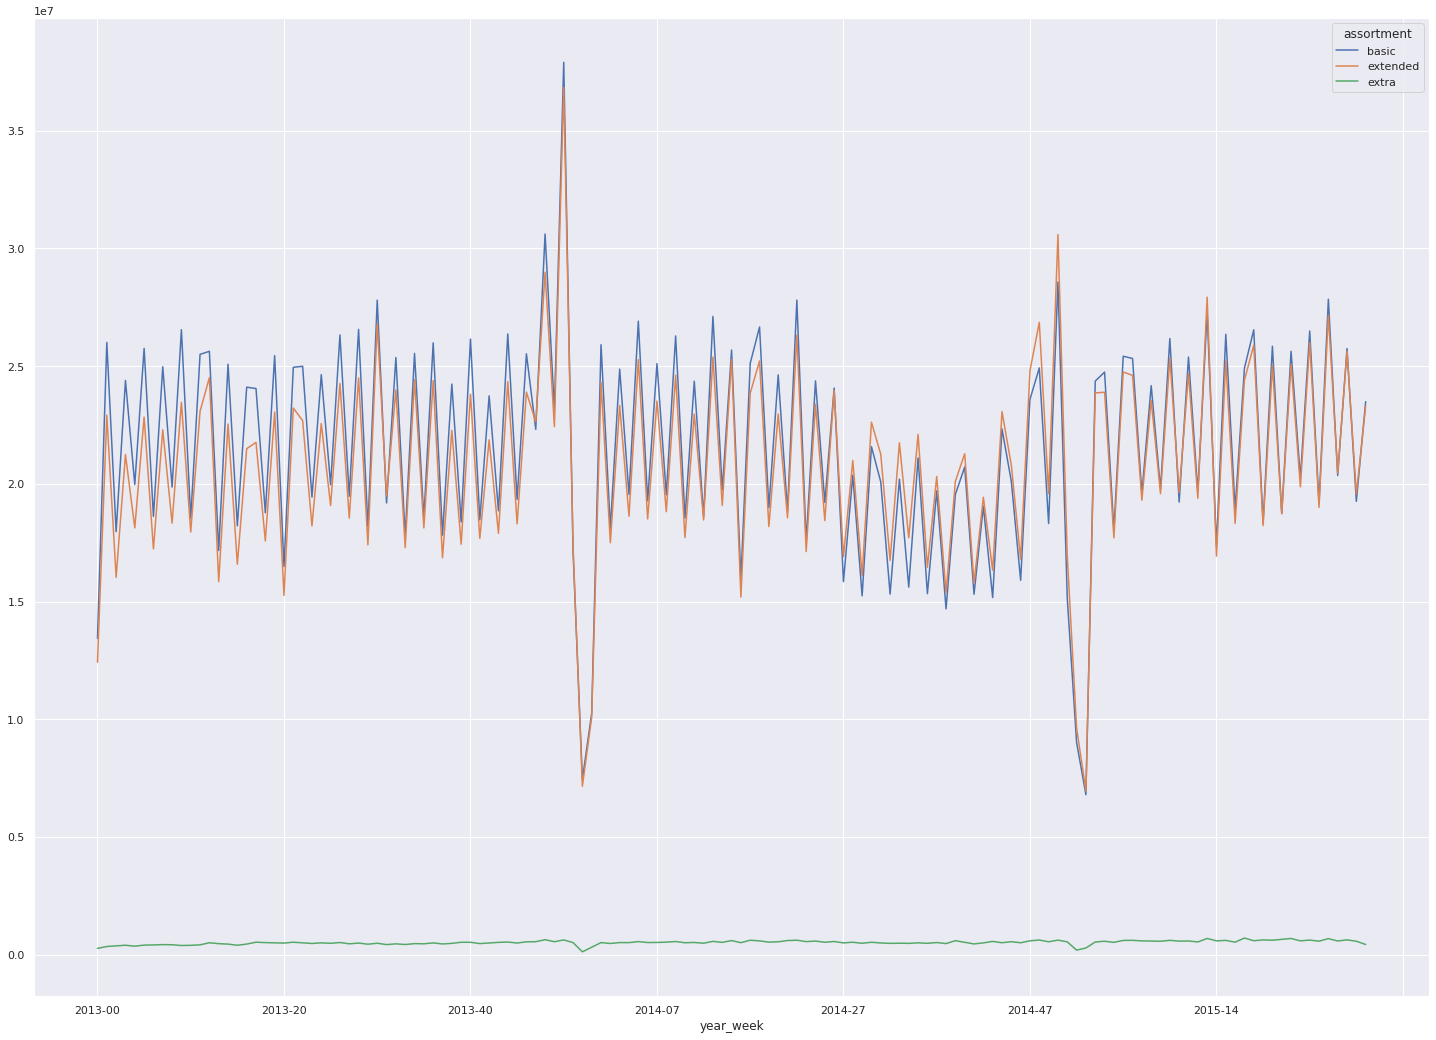

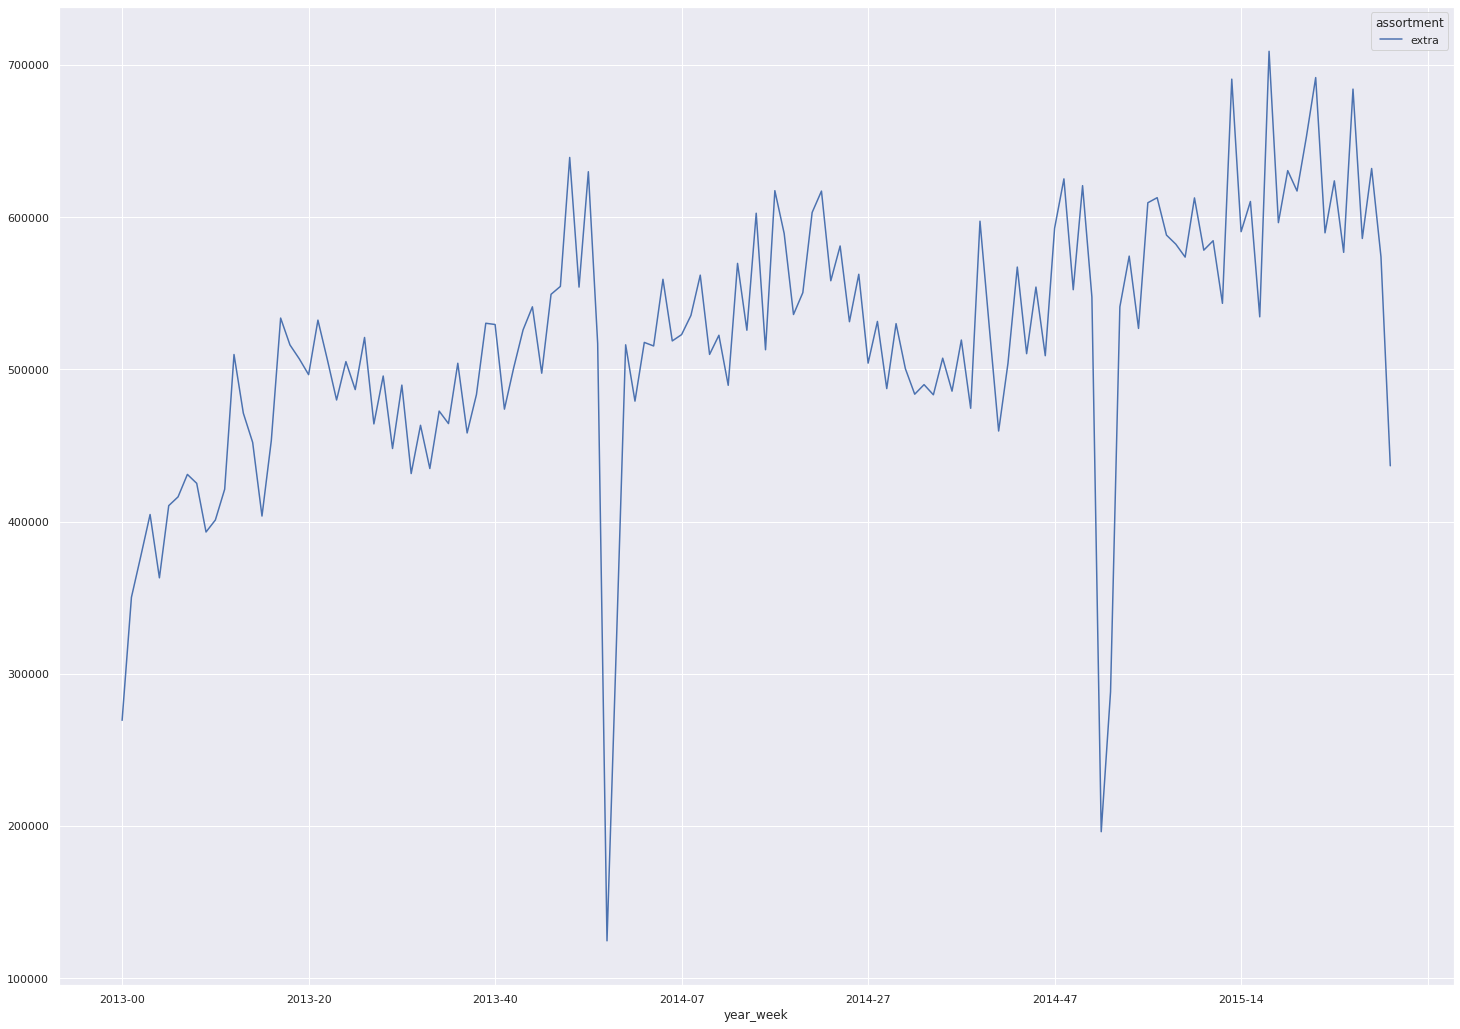

In [34]:
# Relação das vendas em função do mix de produtos (sortimento)

# Seleciona as colunas assortment e sales, agrupa pelo tipo de assortment e soma as vendas de cada grupo e reseta
# o index para obter um DataFrame, atribui o resultado a variável aux1.
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()

# Plota a relação entre as colunas
sns.barplot( x = 'assortment', y = 'sales', data = aux1);

# Segundo o gráfico, lojas com o assortment EXTRA são as que possuem menor volume de vendas

# Inclui na avaliação as vendas semanais, para verificar se houve uma mudança de tendência em algum momento, que 
# indique o pq do assortment EXTRA ter poucas vendas. 
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()

# Para obter um gráfico com melhor informação, devemos inverter as linhas e colunas. .plot ao final gera o gráfico
aux2.pivot( index = 'year_week', columns = 'assortment', values = 'sales').plot()

# Avaliação do EXTRA de forma mais detalhada

# Extrai do AUX2 apenas os dados do assortment EXTRA e salva em AUX3
aux3 = aux2[aux2['assortment'] == 'extra']

# Realiza o pivot para inverter as linhas e colunas e plota o gráfico
aux3.pivot( index = 'year_week', columns = 'assortment', values = 'sales').plot()

### H2. Lojas com competidores mais próximos deveriam vender menos.
**FALSA** - Lojas com **COMPETIDORES MAIS PRÓXIMOS** vendem **MAIS** 


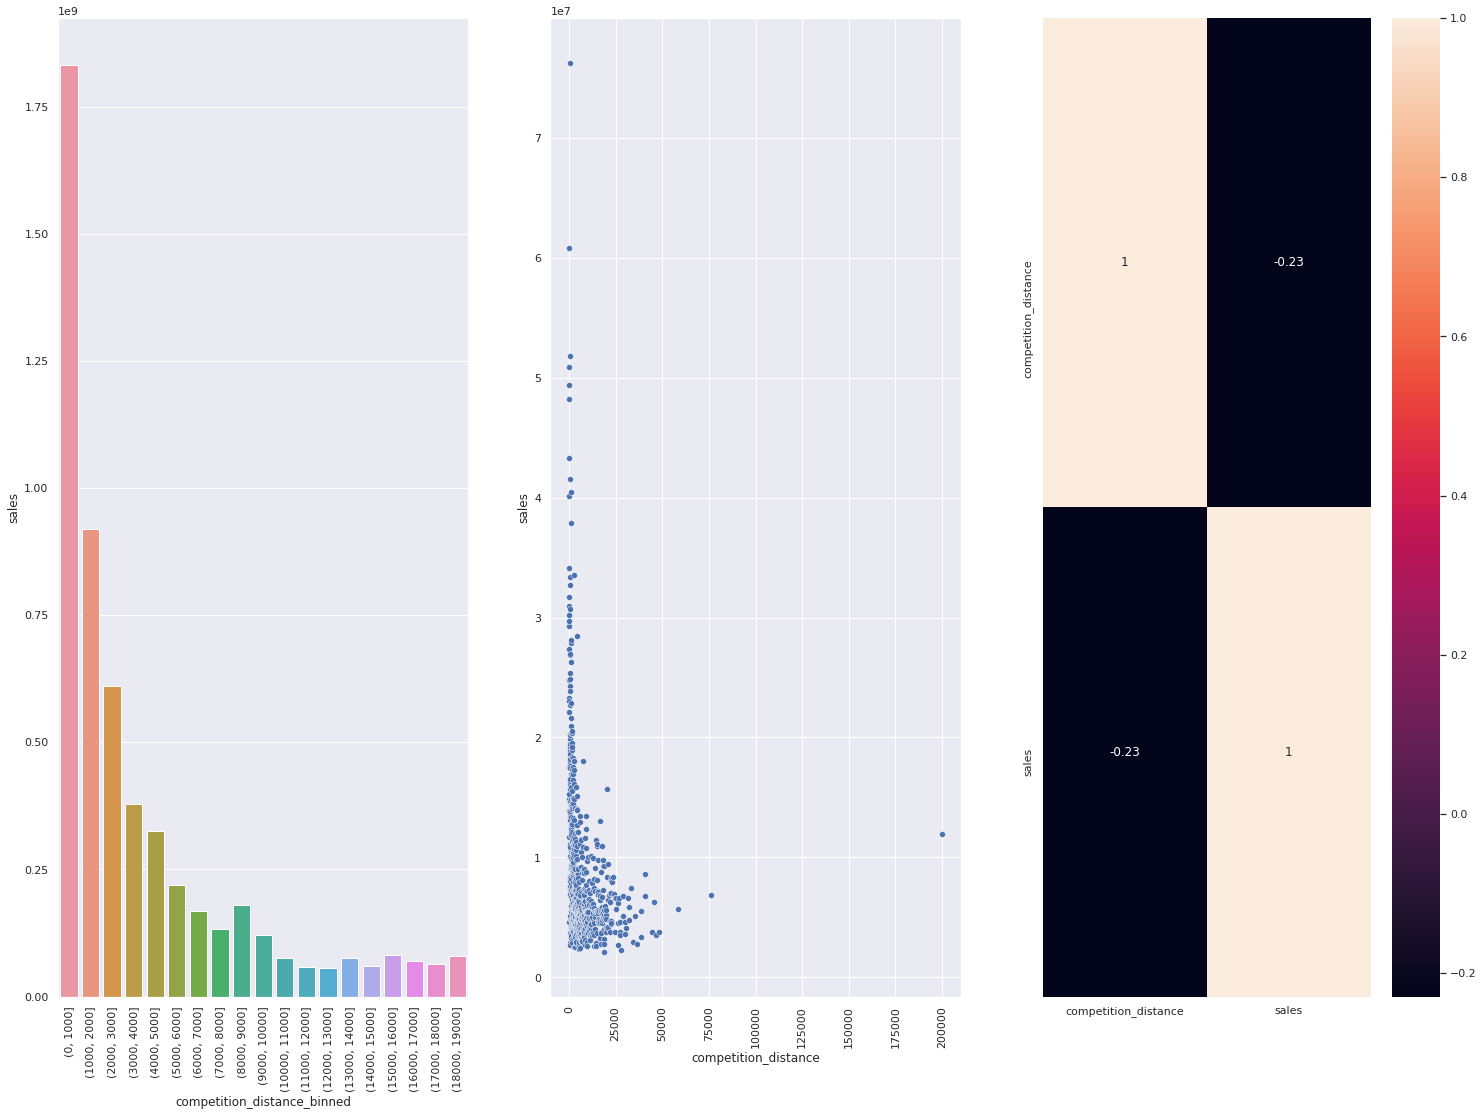

In [35]:
# Relação das vendas em função distância dos competidores

# Seleciona as 'competition_distance' e 'sales', agrupa pelo distância dos competidores, 
# soma as vendas de cada grupo e reseta o index para obter um DataFrame, atribui o resultado a variável aux1.
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

# O resultado acima vai trazer um grupo de dados com granularidade muito alta, uma vez que a distância 
# do competidor pode variar muito.
# A solução é agrupar as distâncias e analisar as vendas em função desses grupos de distância.
# Assim, cria-se uma variável que vai armazenar esse agrupamento chamada BINS
# Cria-se uma lista, onde o np.arrange vai criar faixas de valores começando em 0, indo até 20000, em intervalos
# de 1000 em 1000.
bins = list(np.arange(0, 20000, 1000))

# Após, cria-se uma nova coluna no DF onde serão definidos em qual intervalo cada linha está.
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)

# Realiza o agrupamento das vendas pelas faixas de disTância criadas e soma dentro de cada grupo
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

# Plota o resultado com gráfico de barras
plt.subplot (1, 3, 1)
sns.barplot( x = 'competition_distance_binned', y = 'sales', data = aux2);
plt.xticks (rotation = 90);

# Plota o resultado com scatter para visualizar melhor a concentração dos doados. Usa o AUX1 e 
# competition_distance, pois aqui é melhor que os valores mantenham a granularidade.
plt.subplot (1, 3, 2)
sns.scatterplot( x = 'competition_distance', y = 'sales', data = aux1);
plt.xticks (rotation = 90);


# Este gráfico mede a corelação entre as variáveis, a escala varia de 0 até 1, quanto mais perto de 0 mais fraca
# será a corelação entre as variáveis. Um resultado de 0.23 é considerado bom.
plt.subplot (1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);




### H3. Lojas com competidores há mais tempo deveriam vender mais.
**FALSA** - Lojas com **COMPETIDORES HÁ MAIS TEMPO** vendem **MENOS**

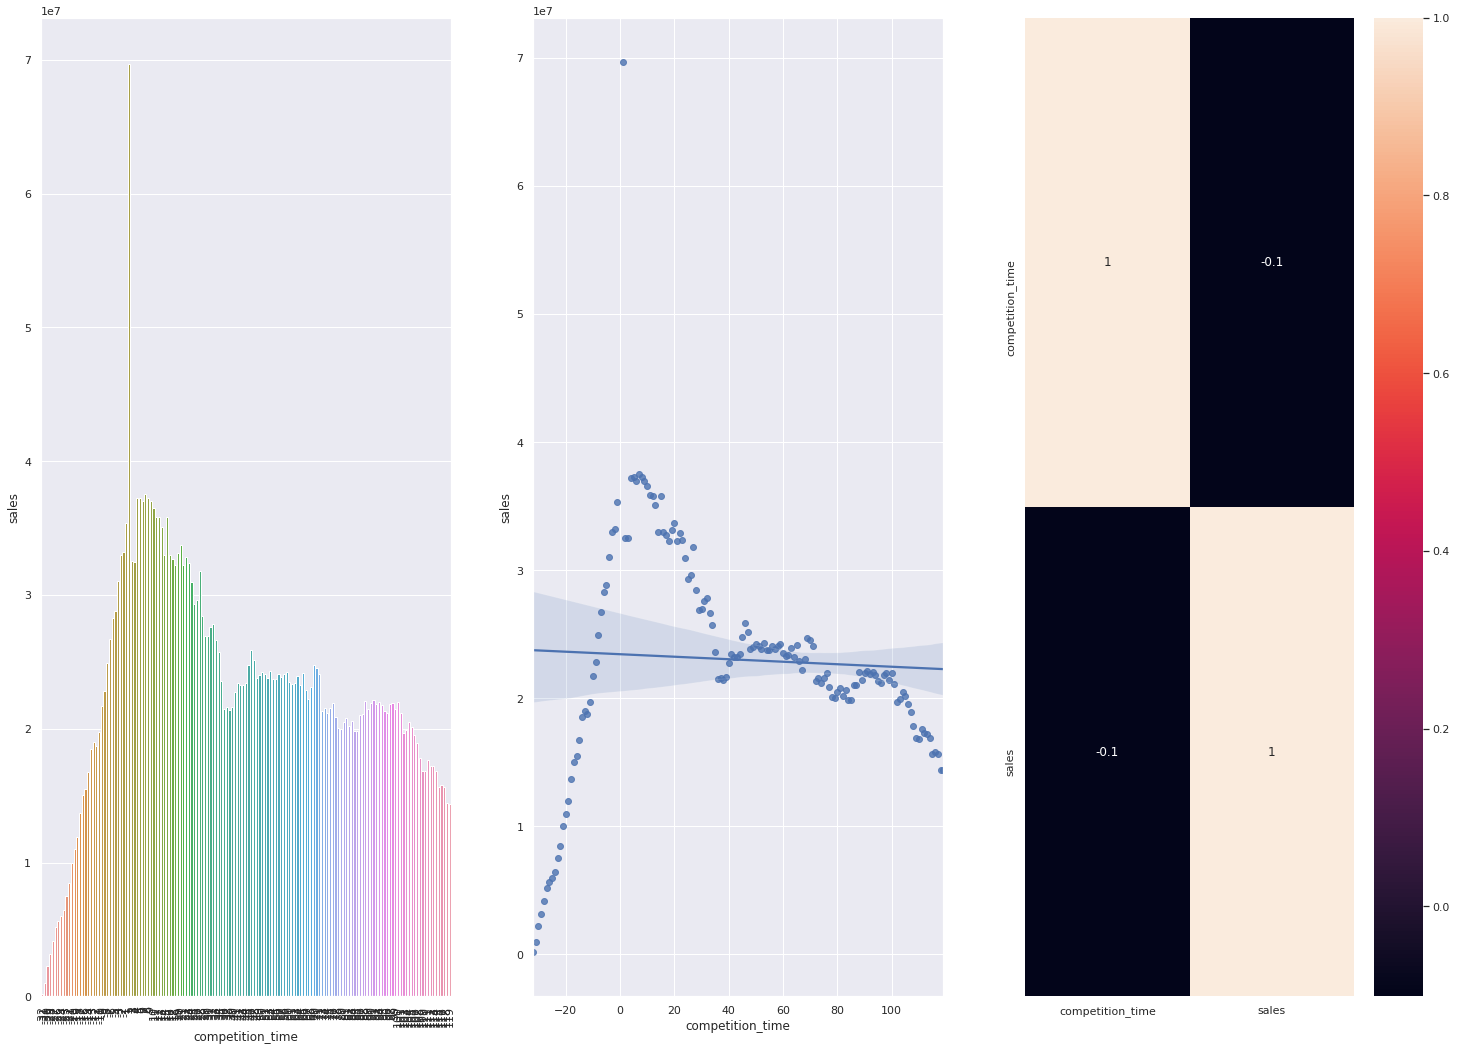

In [36]:
# Relacionar o tempo de abertura da concorrência com o nível de vendas das lojas

aux1 = df4[['competition_time', 'sales']].groupby('competition_time').sum().reset_index()

# O resultado da seleção acima traz uma granularidade muito grande, então é preciso aplicar um filtro para 
# diminuir o número de resultados e ficar possível visulaizar as variações
aux2 = aux1[(aux1['competition_time'] < 120) & (aux1['competition_time'] != 0)]

plt.subplot (1, 3, 1)
sns.barplot (x = 'competition_time' , y = 'sales', data = aux2);
plt.xticks(rotation = 90);
# O gráfico mostra que a proximidade da data de abertura da competição estimula as vendas.

# Gráfico que indica a tendência de vendas nesta situação
plt.subplot (1, 3, 2)
sns.regplot (x = 'competition_time' , y = 'sales', data = aux2);

# Corelação entra as variáveis, 0.1 ainda é considerado bom
plt.subplot (1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** - Lojas com promoções ativas por mais tempo vendem menos, pois com o passar do tempo as vendas caem novamante.

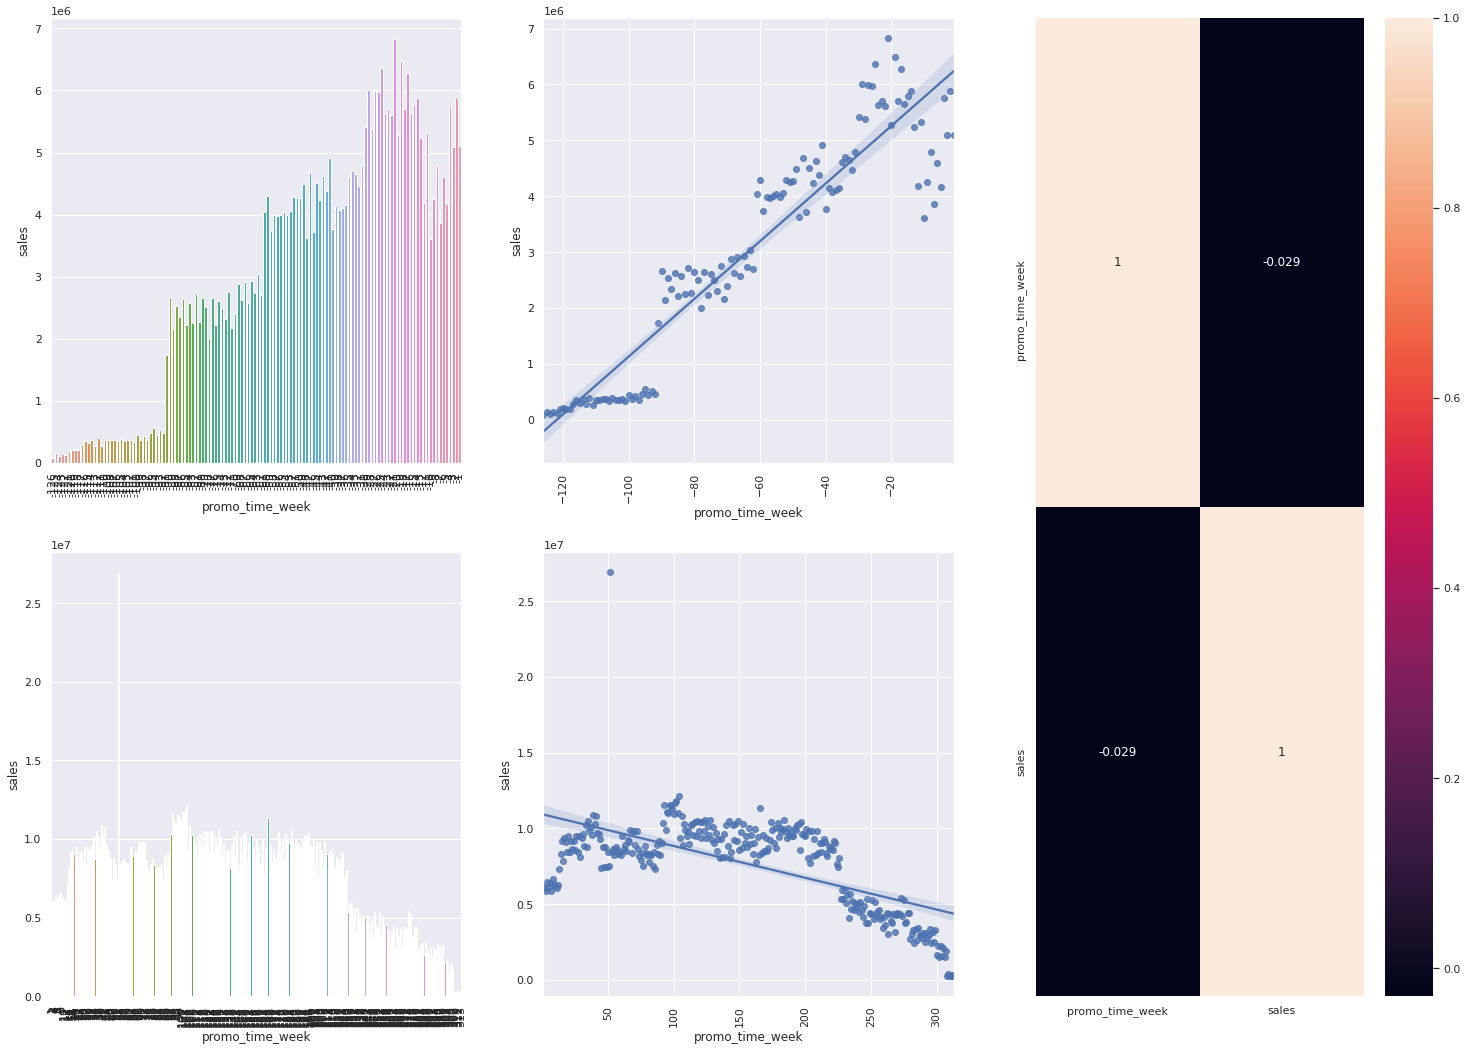

In [37]:
# Seleciona as colunas PROMO_TIME_WEEK e SALES, agrupa pelo PROMO_TIME_WEEK, 
# soma as vendas dentro dos agrupamentos e reseta o index para melhorar a visualização.
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

# O gráfico resultante dos dados acima possuem uma granularidade muito grande e, por consequencia, é impossível fazer uma análise adequada,
# assim, é preciso fazer um recorte nestes dados através de filtragem.
# O resultado negativo (PROMO_TIME_WEEK < 0) significa que a venda foi feita no período de promoção normal e antes do início da promoção extendida, 
# o valor positivo (PROMO_TIME_WEEK > 0) informa que a venda ocorreu durante a promoção extendida.

grid = GridSpec(2, 3)

plt.subplot(grid[0, 0])
aux3 = aux1[aux1['promo_time_week'] < 0] #promoção regular
sns.barplot(x= 'promo_time_week', y= 'sales', data= aux3);
plt.xticks (rotation = 90);

plt.subplot(grid[0, 1])
sns.regplot(x= 'promo_time_week', y= 'sales', data= aux3);
plt.xticks (rotation = 90);

plt.subplot(grid[1, 0])
aux2 = aux1[aux1['promo_time_week'] > 0] #promoção extendida
sns.barplot(x= 'promo_time_week', y= 'sales', data= aux2);
plt.xticks (rotation = 90);

plt.subplot(grid[1, 1])
sns.regplot(x= 'promo_time_week', y= 'sales', data= aux2);
plt.xticks (rotation = 90);

#Força da corelação
plt.subplot(grid[:, 2])
sns.heatmap( aux1.corr( method= 'pearson'), annot=True);
# A corelação de 0.029 é fraca, provavelament não entrará no modelo.

### <s> H5. Lojas com mais dias de promoção deveriam vender mais. </s>

**FALTAM DADOS - Validar no próximo ciclo**

### H6. Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** - Lojas com mais promoções consecutivas vendem menos

In [38]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


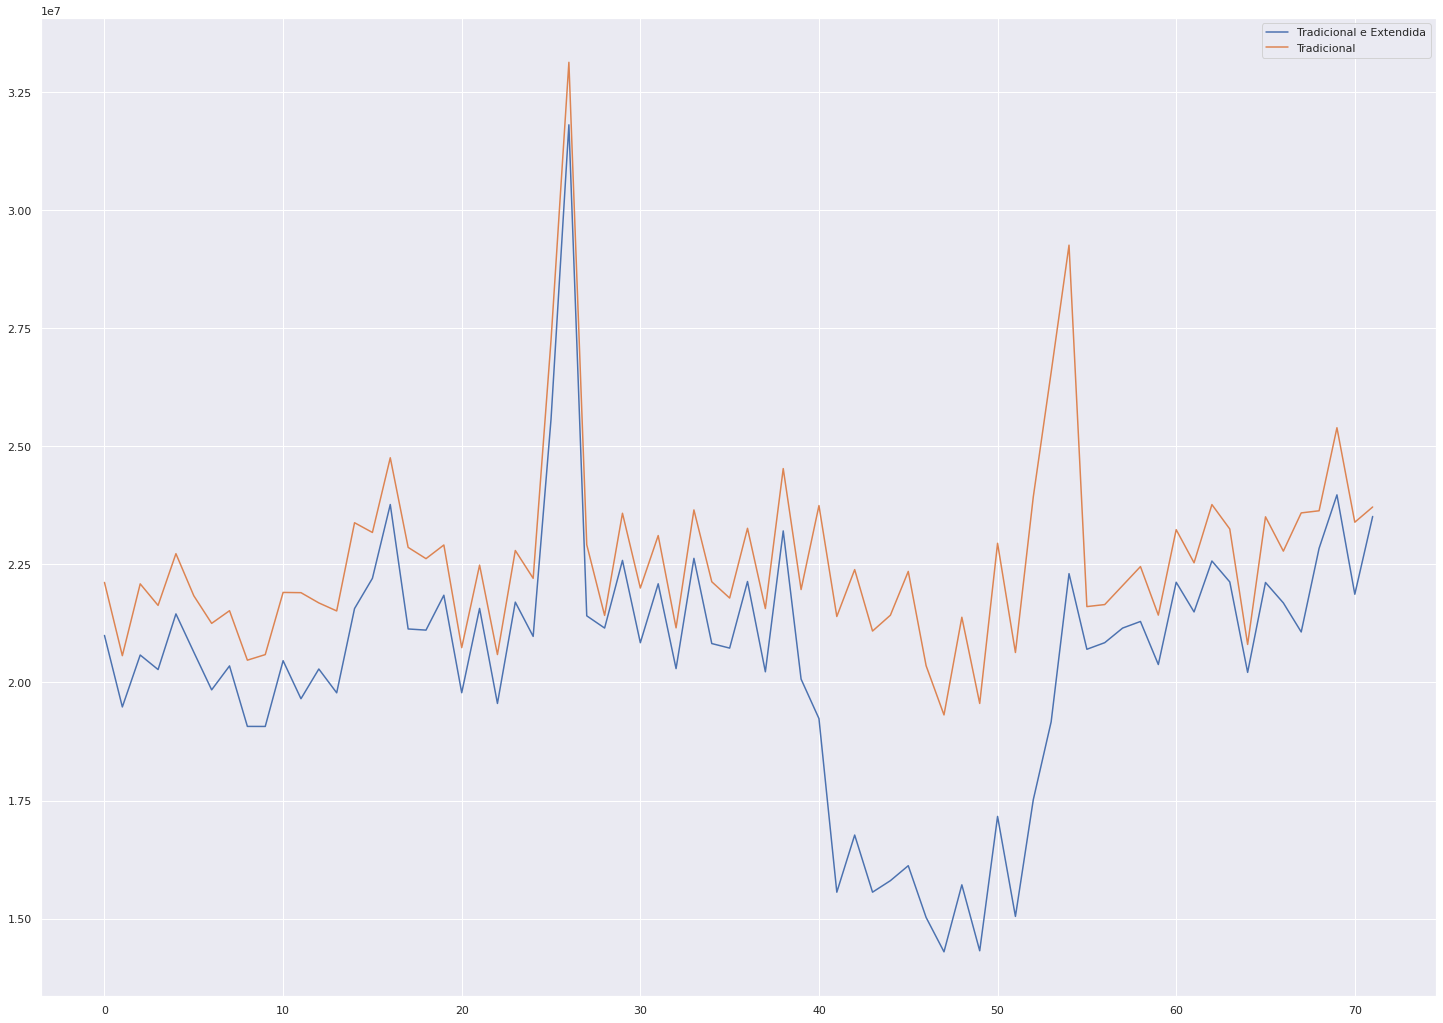

In [39]:
# Seleciona as lojas que participaram dos DOIS PERÍODOS de promoção, agrupa pelas vendas no período
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot();

# Seleciona as lojas que participaram APENAS DO PERÍODO TRADICIONAL de promoção, agrupa pelas vendas no período
aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot( ax=ax);
ax.legend( labels = ['Tradicional e Extendida', 'Tradicional']);

### H7. Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** - Lojas abertas durante o feriado de natal vendem menos

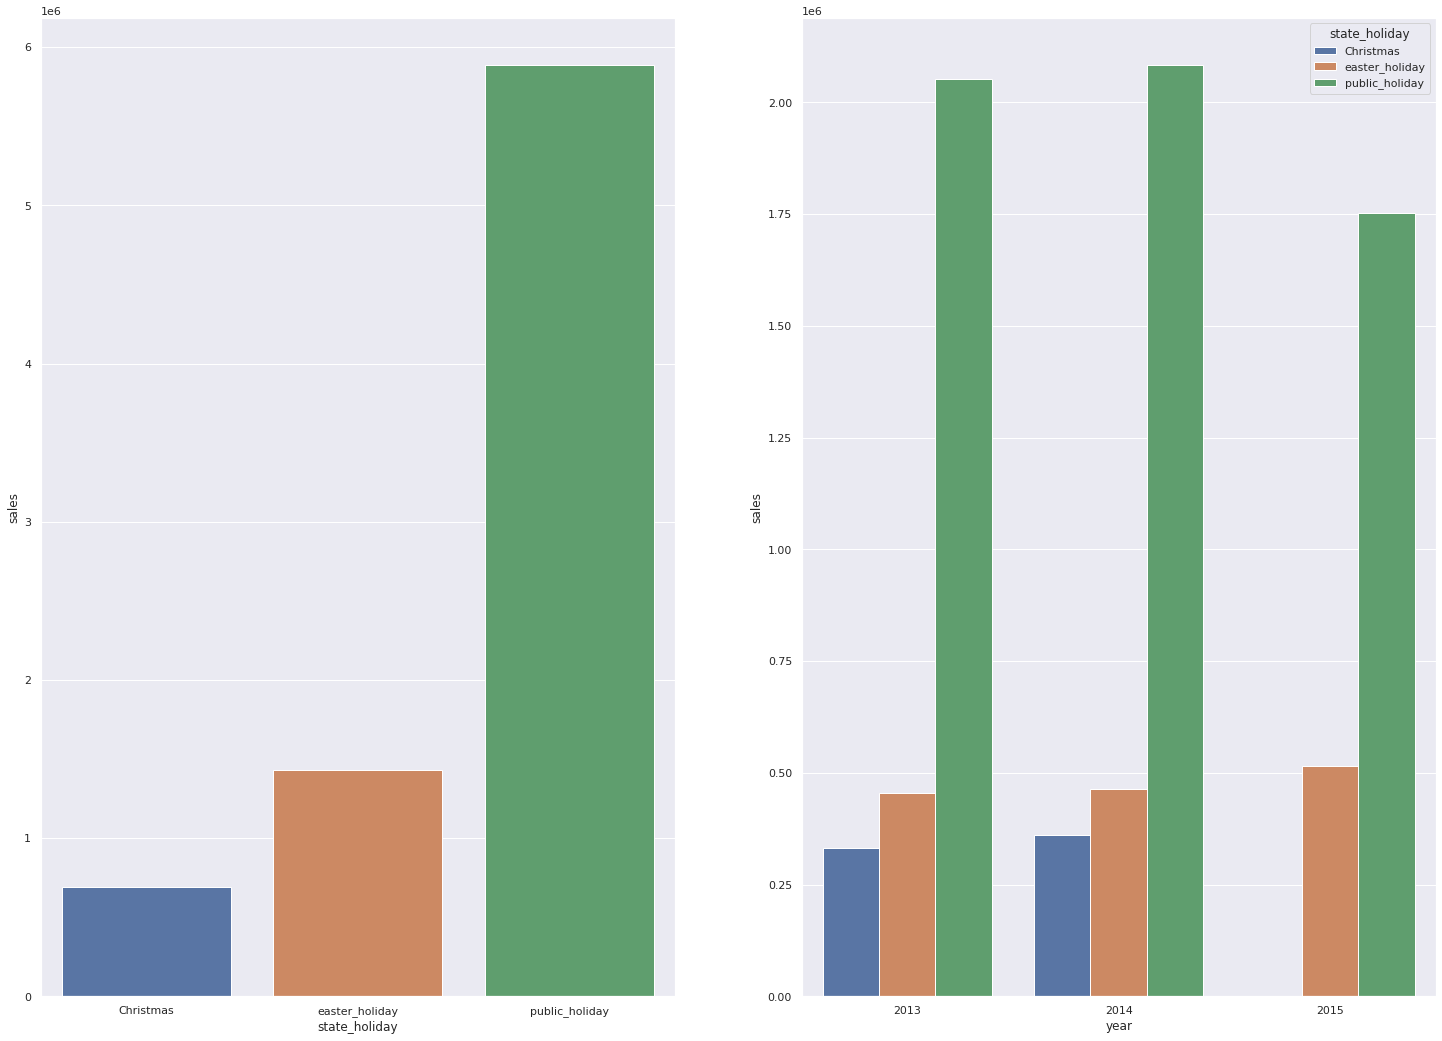

In [40]:
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()

plt.subplot (1, 2, 1)
sns.barplot(x= 'state_holiday', y= 'sales', data= aux1);

aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()

plt.subplot (1, 2, 2)
sns.barplot(x= 'year', y= 'sales', hue= 'state_holiday', data= aux2);

### H8. Lojas deveriam vender mais ao longo dos anos.
**FALSA** - As lojas estão vendendo menos ao longo dos anos.

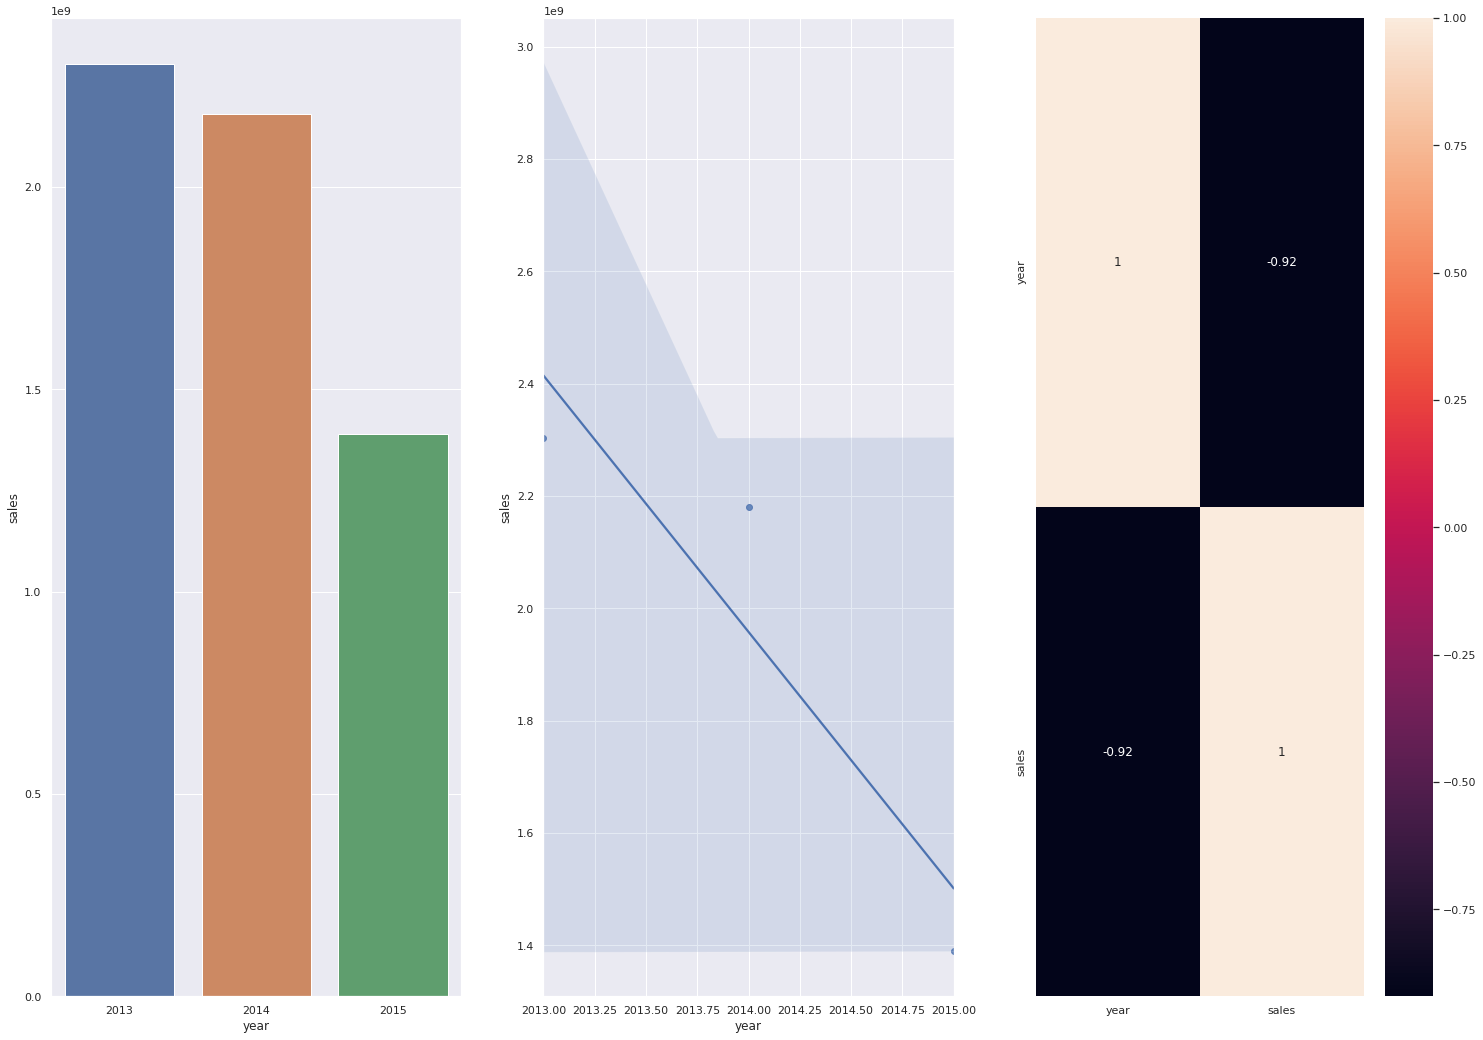

In [41]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()


plt.subplot (1, 3, 1)
sns.barplot(x= 'year', y= 'sales', data= aux1);

plt.subplot (1, 3, 2)
sns.regplot(x= 'year', y= 'sales', data= aux1);

plt.subplot (1, 3, 3)
sns.heatmap(aux1.corr( method = 'pearson'), annot = True);


### H9. Lojas deveriam vender mais no segundo semestre do ano.
**FALSA** - As lojas vendem menos do segundo semestre de cada ano

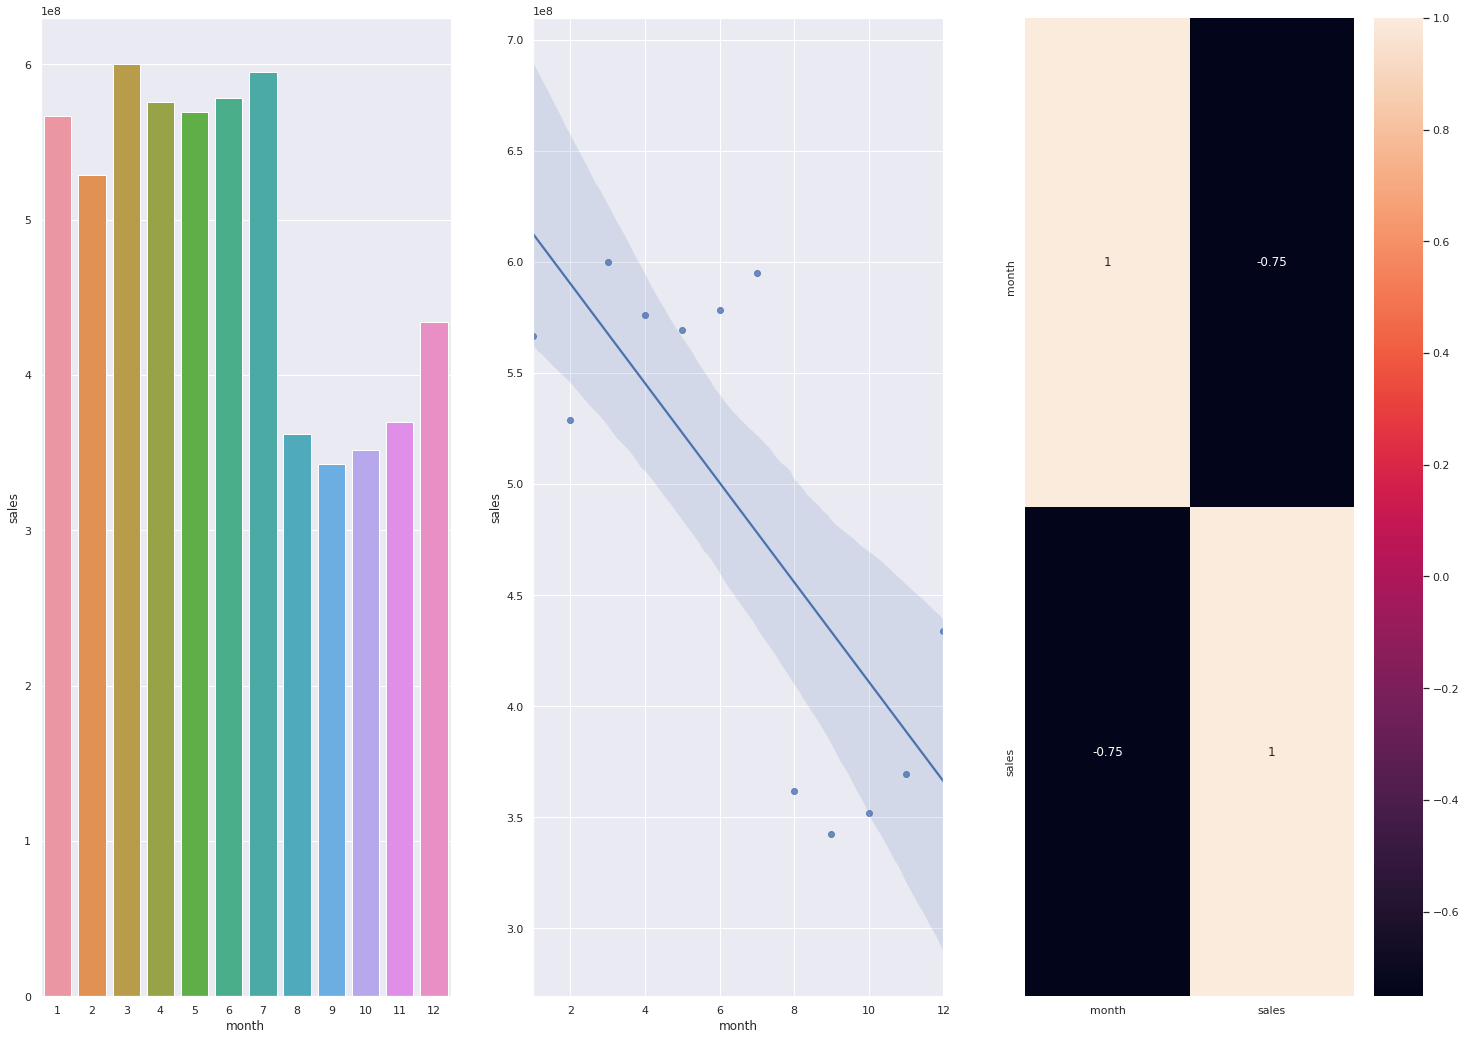

In [42]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()


plt.subplot (1, 3, 1)
sns.barplot(x= 'month', y= 'sales', data= aux1);

plt.subplot (1, 3, 2)
sns.regplot(x= 'month', y= 'sales', data= aux1);

plt.subplot (1, 3, 3)
sns.heatmap(aux1.corr( method = 'pearson'), annot = True);


### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** - As lojas tem uma venda acumulada maior no período após o dia 10.

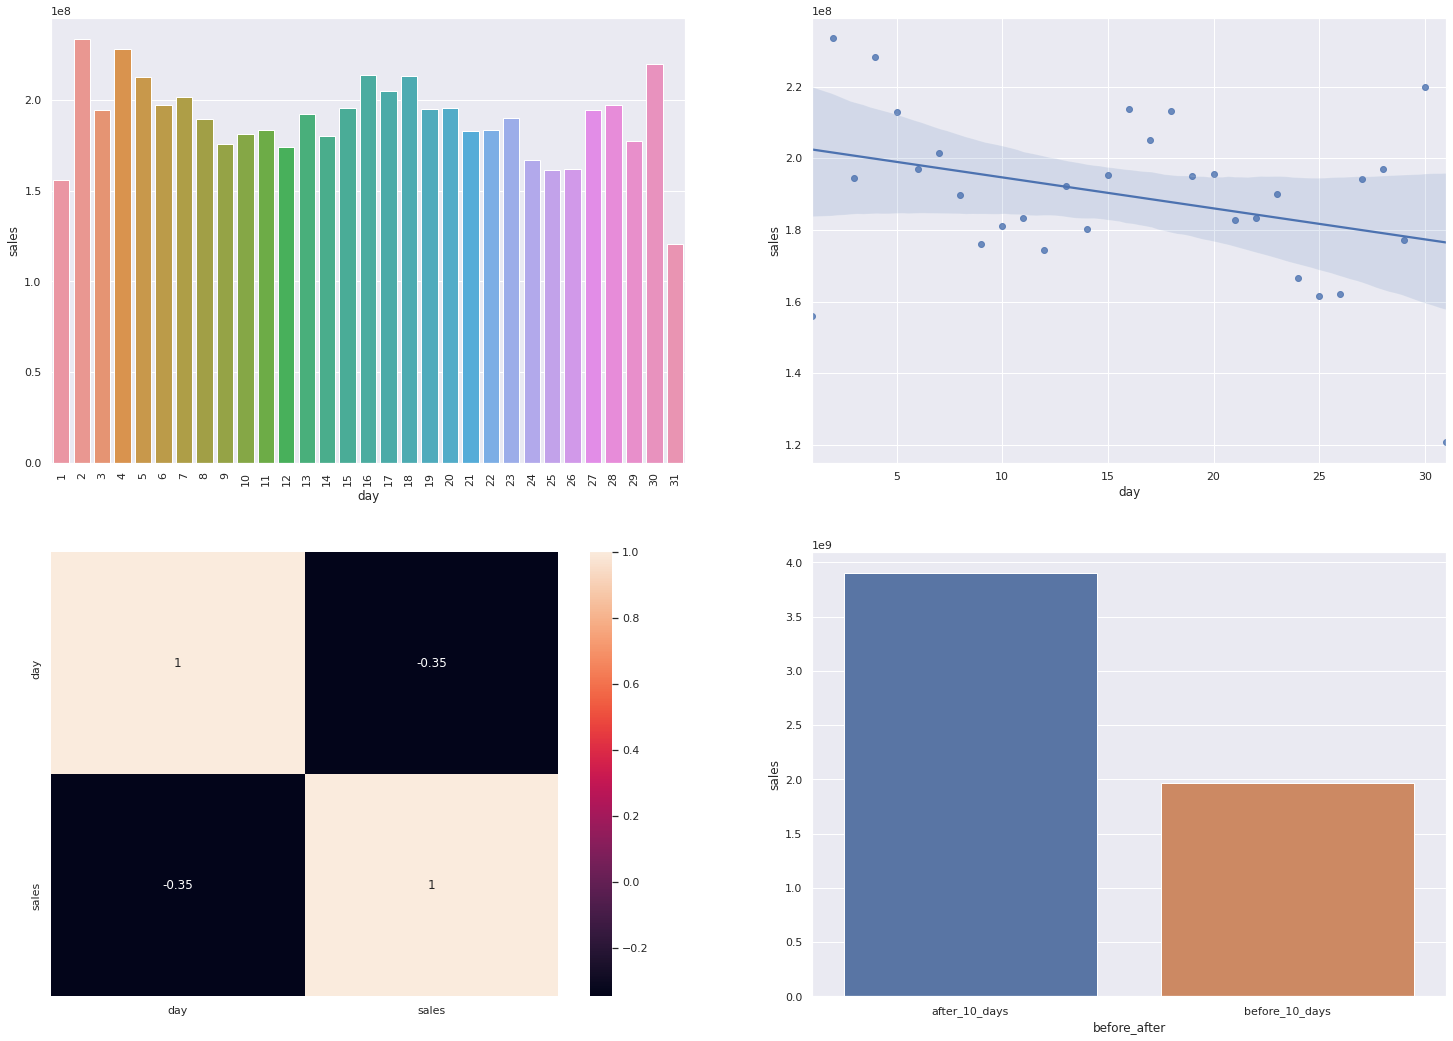

In [43]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot (2, 2, 1)
sns.barplot(x= 'day', y= 'sales', data= aux1);
plt.xticks (rotation = 90);

plt.subplot (2, 2, 2)
sns.regplot(x= 'day', y= 'sales', data= aux1);

plt.subplot (2, 2, 3)
sns.heatmap(aux1.corr( method = 'pearson'), annot = True);

aux1['before_after'] = aux1['day'].apply (lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot (2, 2, 4)
sns.barplot(x= 'before_after', y= 'sales', data= aux2);

### H11. Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** - As lojam vendem menos nos finais de semana.

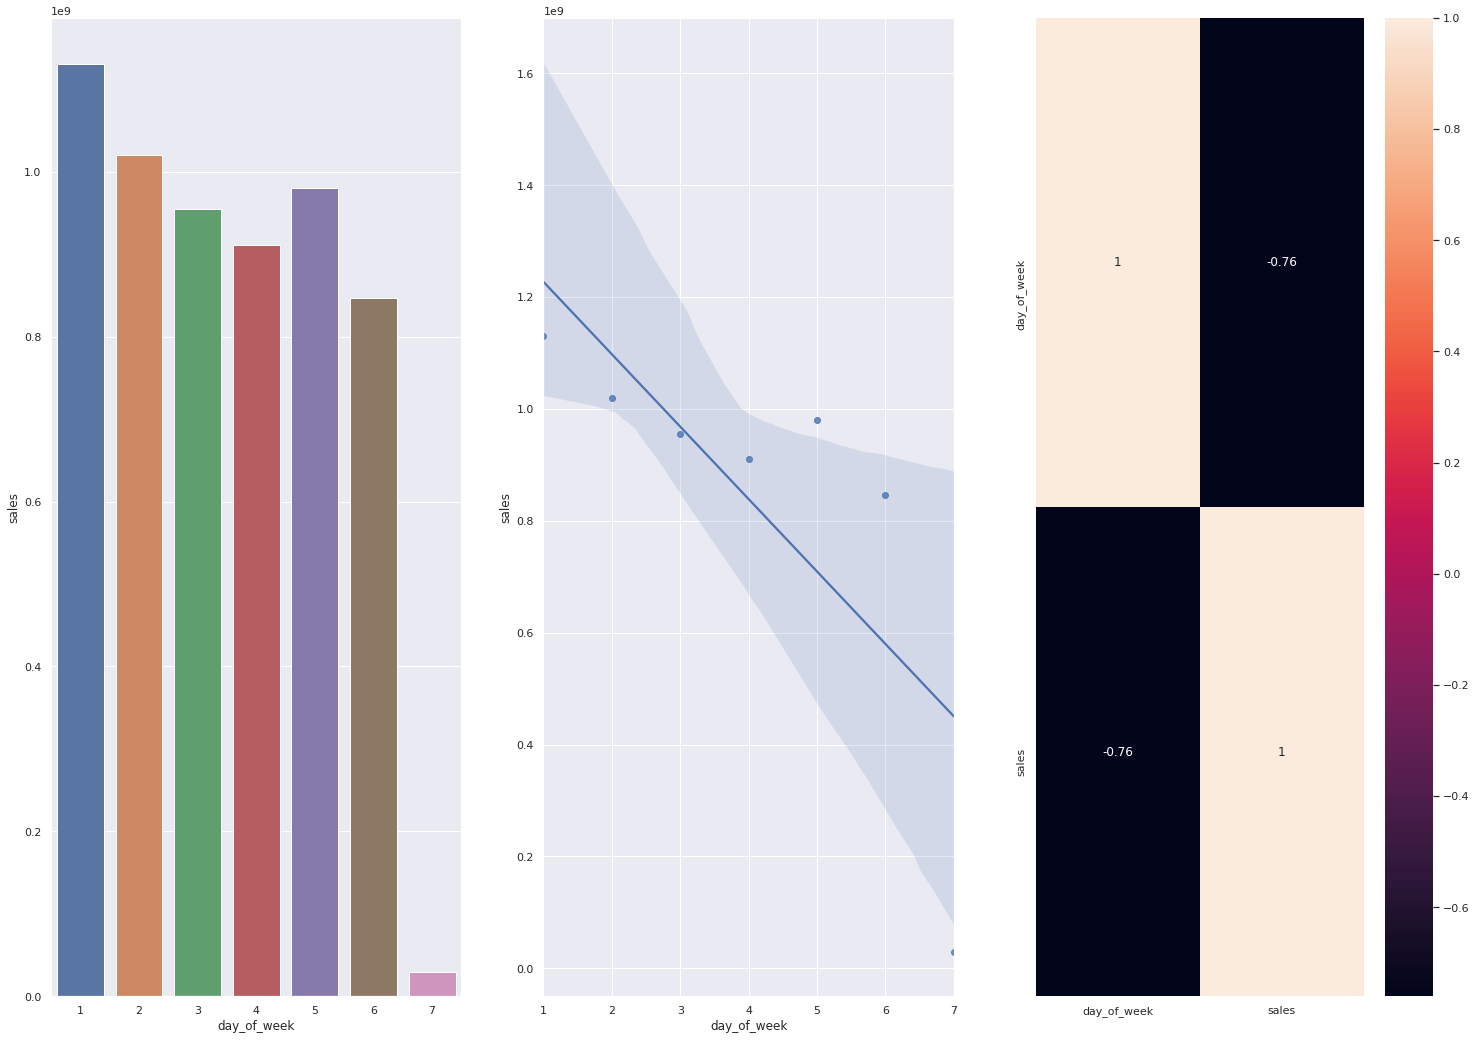

In [44]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot (1, 3, 1)
sns.barplot(x= 'day_of_week', y= 'sales', data= aux1);

plt.subplot (1, 3, 2)
sns.regplot(x= 'day_of_week', y= 'sales', data= aux1);

plt.subplot (1, 3, 3)
sns.heatmap(aux1.corr( method = 'pearson'), annot = True);

### H12. Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** - As lojas vendem menos durante os feriados escolares, exceto no período de férias (Jul e Ago)

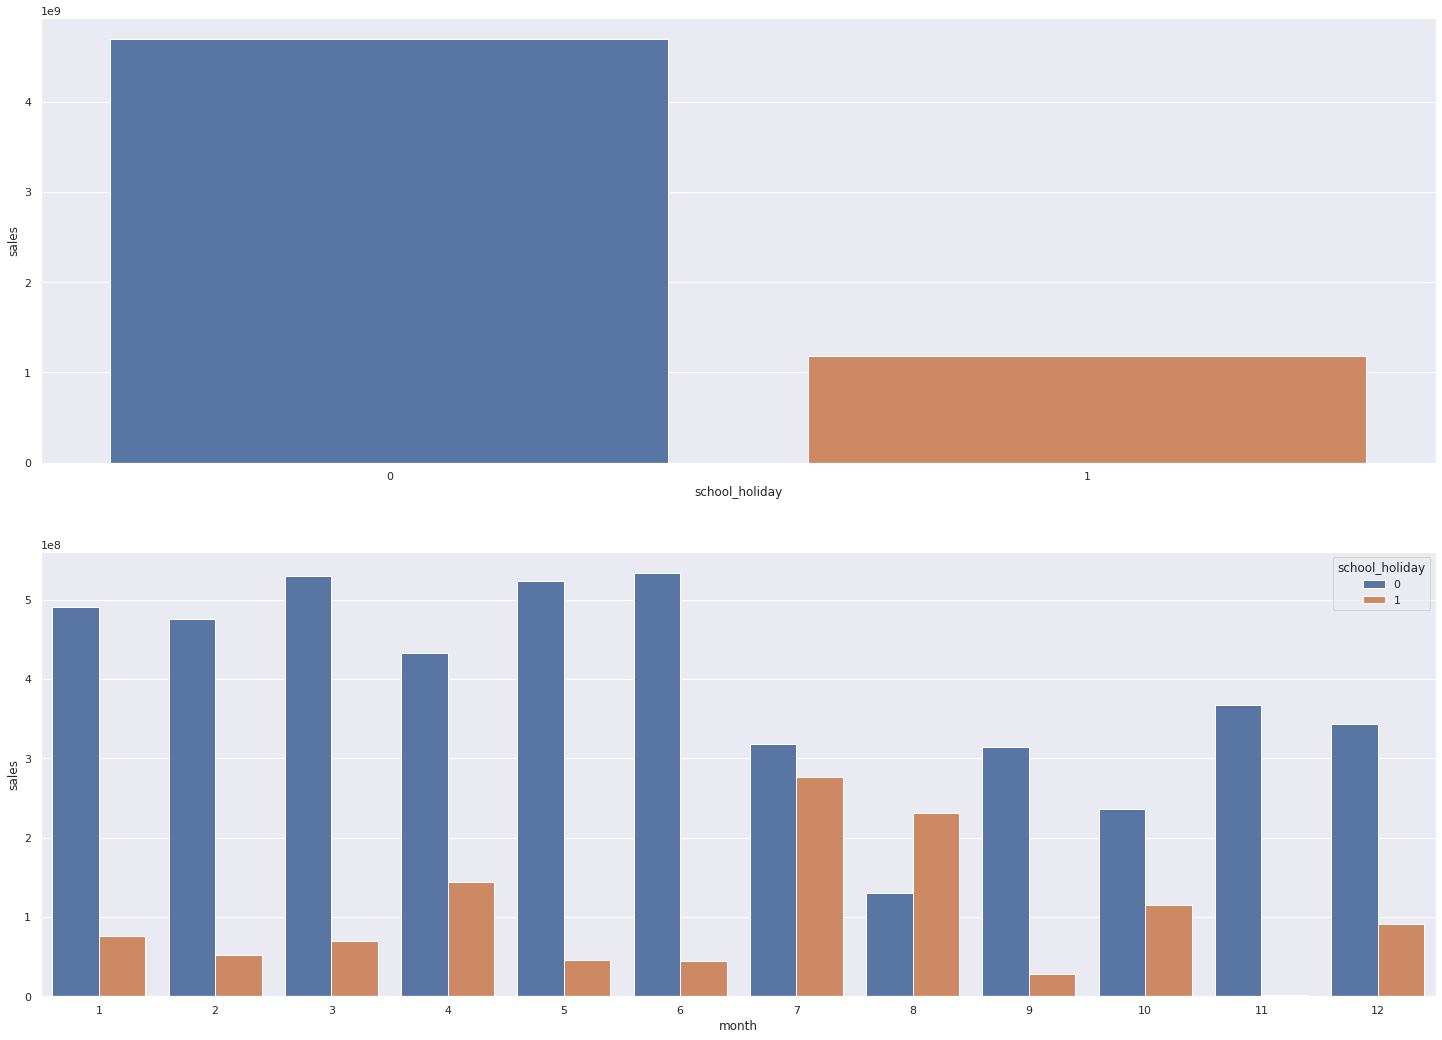

In [45]:
plt.subplot(2, 1, 1)
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x= 'school_holiday', y= 'sales', data= aux1);

plt.subplot(2, 1, 2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x= 'month', y= 'sales', hue= 'school_holiday', data= aux2);


### 4.2.1. Resumo das Hipóteses

In [46]:
tab = [['Hipóteses', 'Conclusão', 'Relevância'],
        ['H1', 'Falsa', 'Baixa'],
        ['H2', 'Falsa', 'Média'],
        ['H3', 'Falsa', 'Média'],
        ['H4', 'Falsa', 'Baixa'],
        ['H5', '-', '-'],
        ['H6', 'Falsa', 'Baixa'],
        ['H7', 'Falsa', 'Média'],
        ['H8', 'Falsa', 'Alta'],
        ['H9', 'Falsa', 'Alta'],
        ['H10', 'Verdadeira', 'Alta'],
        ['H11', 'Verdadeira', 'Alta'],
        ['H12', 'Verdadeira', 'Baixa']      
      ]
print(tabulate(tab, headers= 'firstrow'))

Hipóteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Média
H3           Falsa        Média
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Média
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3. Análise Multivariada

## 4.3.1. Numerical attibutes

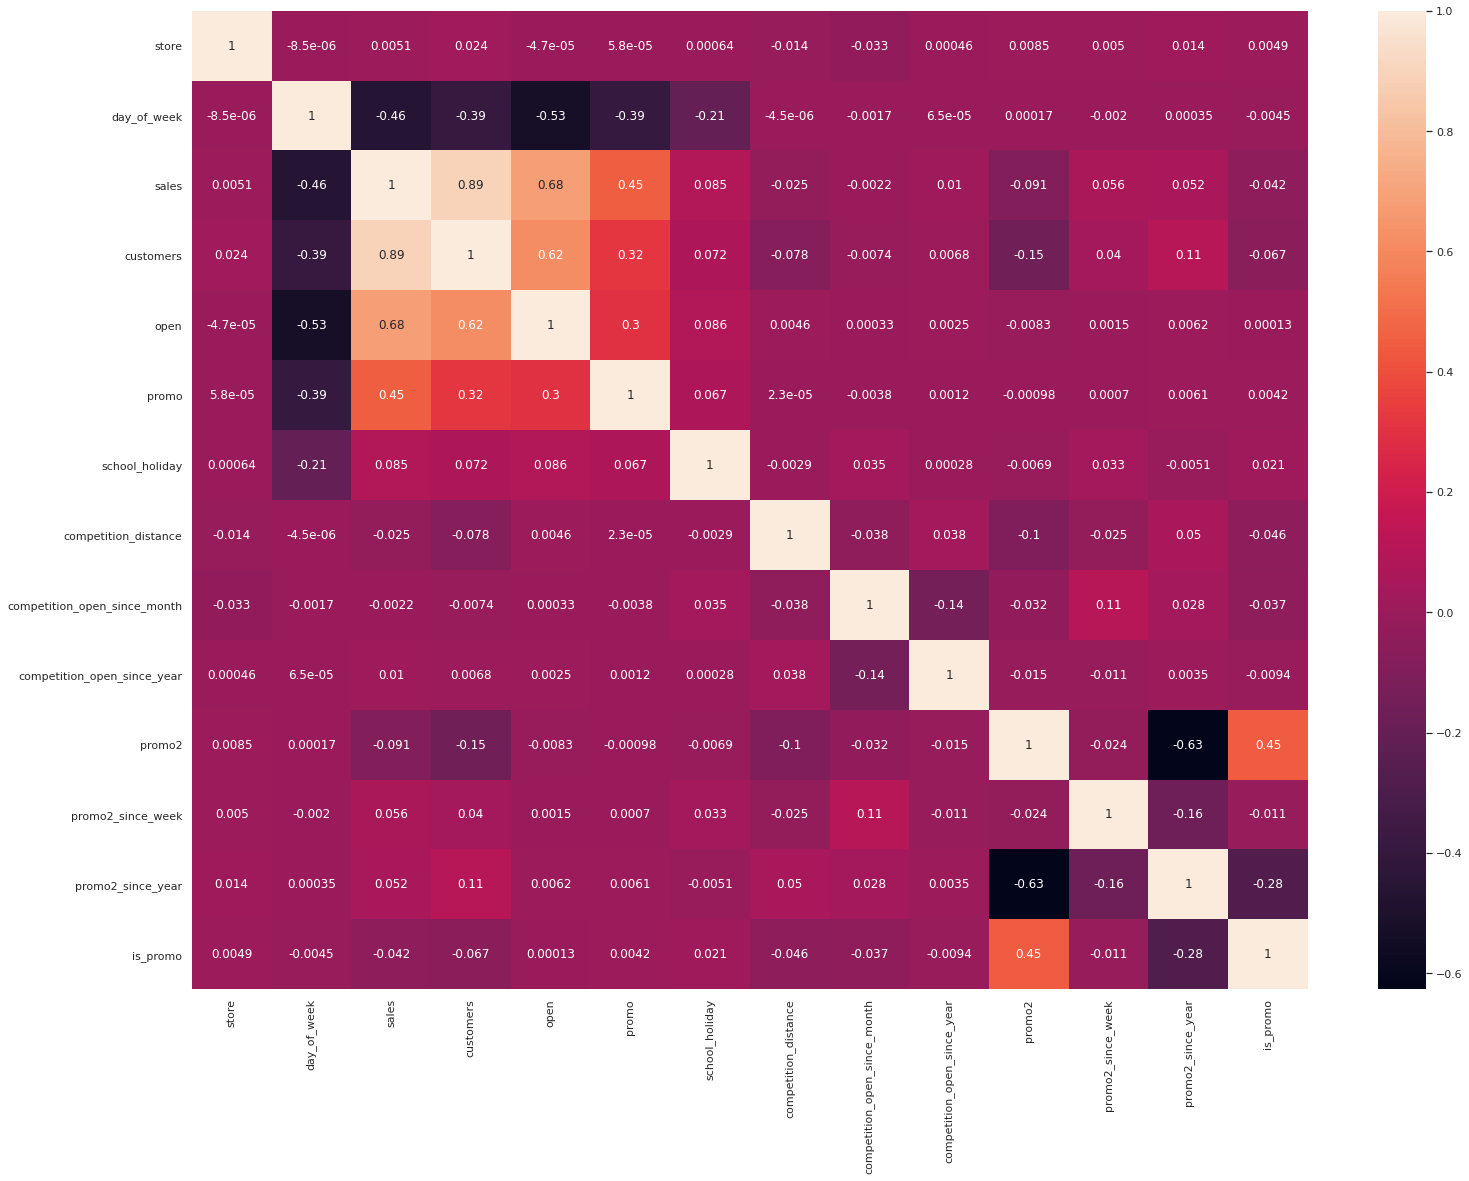

In [47]:
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap( correlation, annot= True);

## 4.3.2. Categorical attributes

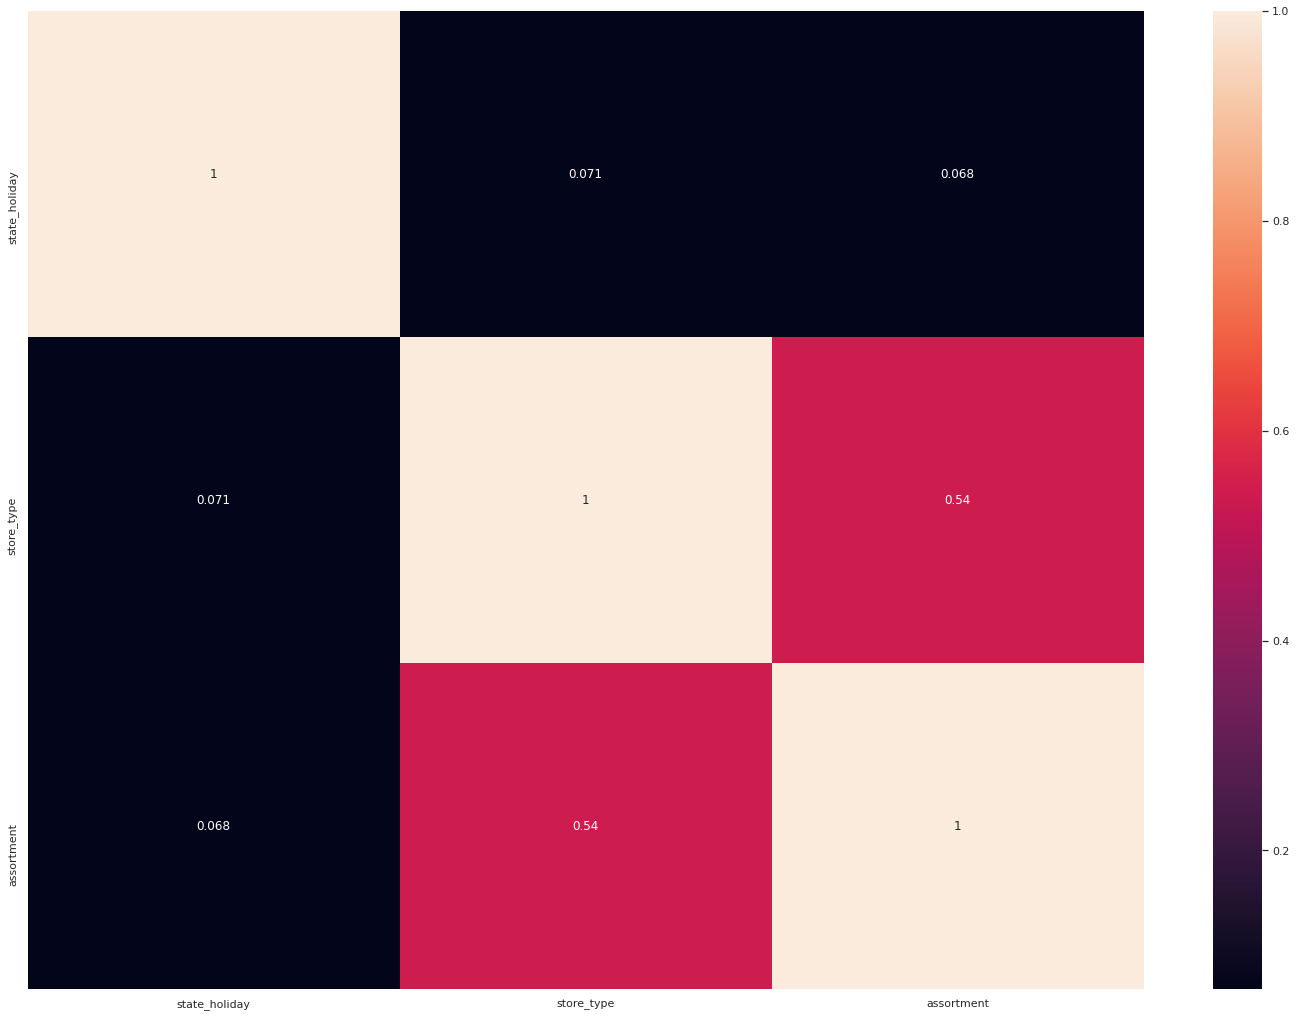

In [48]:
# Atualização do DataSet para incluir as variáveis categóricas que foram criadas ou alteradas durante o projeto
a = df4.select_dtypes( include = 'object')

# Cálculo do V de Cramér
a1 = cramer_v (a['state_holiday'], a['state_holiday'])
a2 = cramer_v (a['state_holiday'], a['store_type'])
a3 = cramer_v (a['state_holiday'], a['assortment'])

a4 = cramer_v (a['store_type'], a['state_holiday'])
a5 = cramer_v (a['store_type'], a['store_type'])
a6 = cramer_v (a['store_type'], a['assortment'])

a7 = cramer_v (a['assortment'], a['state_holiday'])
a8 = cramer_v (a['assortment'], a['store_type'])
a9 = cramer_v (a['assortment'], a['assortment'])

# Dataset final
d = pd.DataFrame ({'state_holiday': [a1, a2, a3],
                'store_type': [a4, a5, a6],
                'assortment': [a7, a8, a9] })
d = d.set_index( d.columns)

sns.heatmap(d, annot = True);

# 5.0. DATA PREPARATION

In [49]:
df5 = df4.copy()

## 5.1. Normalização

In [50]:
# Não há variáveis normais, portanto é melhor não forçar a normalização.

## 5.2. Rescaling

In [51]:
# RobustScaler - Usar quando a variável possuir muitos outliers - plotar um boxplot para verificar a existência dos outliers
# RobustScaler >>> rs.fit_transform() vai encontrar os quartis e aplicar a fórmula
rs = RobustScaler()

# MinMaxScaler - Usar quando a variável tiver poucos outliers
# MinMaxScaler >>> mms.fit_transform() vai encontrar as variáveis e aplicar a fórmula
mms = MinMaxScaler()

# competition_distance - RobustScaler
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values)
pickle.dump (rs, open ('parameter/competition_distance_scaler.pkl', 'wb'))

# competition_time - RobustScaler
df5['competition_time'] = rs.fit_transform( df5[['competition_time']].values)
pickle.dump (rs, open ('parameter/competition_time_scaler.pkl', 'wb'))

# promo_time_week - MinMaxScaler
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values)
pickle.dump (mms, open ('parameter/promo_time_week_scaler.pkl', 'wb'))

# year - MinMaxScaler
df5['year'] = mms.fit_transform( df5[['year']].values)
pickle.dump (mms, open ('parameter/year_scaler.pkl', 'wb'))

## 5.3. Transformação

### 5.3.1. Encoding

In [52]:
# state_holiday - variável que reflete um estado/situação (dia regular ou feriado) - ONE HOT ENCODING
df5 = pd.get_dummies (df5, prefix = ['state_holiday'], columns = ['state_holiday'])

# store_type - não há como verificar se existe uma ordem de importância - LABEL ENCODING
le = LabelEncoder()
df5 ['store_type'] = le.fit_transform( df5['store_type'])
pickle.dump (le, open ('parameter/store_type_scaler.pkl', 'wb'))

# assortment - Existe certa hierarquia entre os dados - ORDINAL ENCODING
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2. Response Variable Transformation

In [53]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3. Nature Transformation

In [54]:
# month - os meses de um ano formam um ciclo de 1 até 12 - TRANSFORMAÇÃO CÍCLICA
df5['month_sin'] = df5['month'].apply(lambda x: np.sin (x * (2 * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos (x * (2 * np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin (x * (2 * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos (x * (2 * np.pi/30)))


# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin (x * (2 * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos (x * (2 * np.pi/52)))


# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin (x * (2 * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos (x * (2 * np.pi/7)))

# 6.0. FEATURE SELECTION

In [55]:
df6 = df5.copy()

## 6.1. Split DataFrame into training and teste dataset

In [56]:
# Deletar as variáveis que foram derivadas para novas variáveis na etapa de Feature Engineering
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis = 1)

In [57]:
# Separar o modelo em duas partes:
# TREINO: dados do primeiro dia de vendas até 6 semanas anteriores ao último dia
# TESTE: dados do último dia de vendas até 6 semana para trás
# Vai aplicar o modelo no TREINO e comparar o resultado com o TESTE, para verificar a acurácia.

# Passo 1: agrupar o DataSet por data de venda, para saber o primeiro dia e o último dia

# df6[['store', 'date']].groupby('store').min().reset_index()
# PRIMEIRO DIA DE VENDAS: **2013-01-02**

# df6[['store', 'date']].groupby('store').max().reset_index()
# ÚLTIMO DIA DE VENDAS: **2015-07-31**

# Descobrir qual é a data do último dia de vendas, menos as seis semanas

df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta ( days = 7 * 6 )
# ÚLTIMO DIA DE VENDAS menos as 6 semanas: **2015-06-19**

Timestamp('2015-06-19 00:00:00')

In [58]:
# Filtrar o DataSet para separar nas duas bases de dados

# TREINO
X_train = df6[df6['date'] < '2015-06-19']
Y_train = X_train['sales']

# TEST
X_test = df6[df6['date'] >= '2015-06-19']
Y_test = X_test['sales']

# Testando para saber se pegou as datas corretas
print('TRAINING DATES')
print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print('\nTESTING DATES')
print( 'Test Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

TRAINING DATES
Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

TESTING DATES
Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


### 6.2. Boruta as Feature Selector

In [59]:
# Definir o DataSet de treino e teste para o Boruta
# X_TRAIN >>> Exclui as colunas data e sales, por serem dados para treino, 
# e separa apenas os valores, pois o Boruta precisa receber apenas um vetor
# Y_TRAIN >>> Extrai apenas os valores e usa o .ravel() para gerar o vetor

X_train_n = X_train.drop(['date', 'sales'], axis = 1).values
Y_train_n = Y_train.values.ravel()

In [60]:
# Definições RANDOM FOREST REGRESSOR
# n_jobs = -1 (faz com que sejam usados todos os cores da máquina, 
# criando as árvores em paralelo, acelerando o processo)

# rf = RandomForestRegressor (n_jobs = -1)

In [61]:
# Definições BORUTA
# rf >>> qual modelo de ML vai ser usado (rf = RandomForest)
# n_estimators >>> nº de estimativas (auto = o algoritmo determina)
# verbose >>> = 2 (visualisar o progresso)
# random_state >>> define o início do processo (pode ser qualquer número, apenas define que todos os ciclos comecem do mesmo lugar)
# .fit >>> informa onde aplicar o algoritmo (não pode ser um DataFrame, precisa ser dois vetores)

# boruta = BorutaPy (rf, n_estimators= 'auto', verbose = 2, random_state = 42).fit(X_train_n, Y_train_n)

### 6.2.1. Best Features from Boruta

In [62]:
# Valores de relevância obtidos pelo algoritmo

# cols_selected = boruta.support_.tolist()

# Filtra e relaciona o index fornecido pelo Boruta com o nome das colunas do DataFrame

# X_train_fs = X_train.drop(['date', 'sales'], axis = 1)
# cols_selected_boruta = X_train_fs.iloc[ : , cols_selected].colunms.to_list[]

# Listar as features que foram excluídas

# colunms_not_selected_boruta = list (np.setdif1d(X_train_fs.colunms, cols_selected_boruta))

In [63]:
# cols_selected_boruta

In [64]:
# colunms_not_selected_boruta

In [65]:
# O passo seguinte seŕa comparar os resultados do BORUTA com os dados obtidos na
# ANÁLISE EXPLORATÓRIA DE DADOS e decidir quais variáveis serão usadas.

### 6.3. Manual Feature Selection

In [66]:
# cols_selected_boruta = 'copiar o resultado obtido acima e incluir o month_sin e o week_of_year_sin'

cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_cos',
    'month_sin',
    'day_cos',
    'day_sin',
    'week_of_year_cos',
    'week_of_year_sin']

In [67]:
# Recolocar as váriáveis retiradas para treino do Boruta
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()

cols_selected_boruta_full.extend( feat_to_add )

In [68]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'month_sin',
 'day_cos',
 'day_sin',
 'week_of_year_cos',
 'week_of_year_sin']

In [69]:
cols_selected_boruta_full

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'month_sin',
 'day_cos',
 'day_sin',
 'week_of_year_cos',
 'week_of_year_sin',
 'date',
 'sales']

# 7.0. MACHINE LEARNING MODELLING

In [70]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Cria o DataSet de treino para a validação
x_training = X_train[ cols_selected_boruta_full ]

## 7.1. Average Model

In [71]:
# Faz uma cópia do x_test
aux1 = x_test.copy()

# Inclui a variável 'sales'
aux1 ['sales'] = Y_test.copy()

# Calcula a média das vendas por loja, reseta o index e renomeia a coluna 'sales', para 'predictions'
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename( columns = {'sales': 'predictions'})
# Reescreve o aux1, através da união entre as duas tabelas, incluindo a média calculada
aux1 = pd.merge( aux1, aux2, how = 'left', on = 'store')
yhat_baseline = aux1['predictions']

# Cálculo da performance dos modelos. Aplica a exponencial para reverter o log que foi aplicado no passo 5, durante as preparações das variáveis.
baseline_result = ml_error('Average Model', np.expm1(Y_test), np.expm1(yhat_baseline))

In [72]:
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression Model

In [73]:
# model
lr = LinearRegression().fit(x_train, Y_train)

# prediction
yhat_lr = lr.predict (x_test)

# performance
lr_result = ml_error ('Linear Regression', np.expm1(Y_test), np.expm1(yhat_lr))

In [74]:
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1. Linear Regression Model - Cross validation

In [75]:
lr_result_CV = cross_validation (x_training, 5, 'Linear Regression', lr, verbose = False)
lr_result_CV

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73+/-295.63,0.3+/-0.02,2952.52+/-468.37


## 7.3. Linear Regression Regularized Model - LASSO

In [76]:
# model
lrr = Lasso( alpha = 0.01).fit(x_train, Y_train)

# prediction
yhat_lrr = lrr.predict (x_test)

# performance
lrr_result = ml_error ('Linear Regression - Lasso', np.expm1(Y_test), np.expm1(yhat_lrr))

In [77]:
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1. LASSO - Cross validation

In [78]:
lrr_result_CV = cross_validation (x_training, 5, 'LASSO', lrr, verbose = False)
lrr_result_CV

,Model Name,MAE CV,MAPE CV,RMSE CV
0,LASSO,2116.38+/-341.5,0.29+/-0.01,3057.75+/-504.26


## 7.4. Random Forest Regressor

In [79]:
# model
# n_jobs = -1 (faz com que sejam usados todos os cores da máquina, criando as árvores em paralelo, acelerando o processo)
# n_estimators = 100 (define o número de ramificações que vão ser criadas)
# andom_state >>> define o início do processo (pode ser qualquer número, apenas define que todos os ciclos comecem do mesmo lugar)

rf = RandomForestRegressor( n_estimators = 25, n_jobs = -1, random_state = 42).fit(x_train, Y_train)

# prediction
yhat_rf = rf.predict (x_test)

# performance
rf_result = ml_error ('Random Forest Regressor', np.expm1(Y_test), np.expm1(yhat_rf))

In [80]:
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,688.706981,0.101279,1026.585808


### 7.4.1 Random Forest Regressor - Cross validation

In [81]:
#rf_result_CV = cross_validation (x_training, 3, 'Random Forest Regressor', rf, verbose = True)
#rf_result_CV

## 7.5. XGBoost Regressor 

In [82]:
# >>> model
#model_xgb = xgb.XGBRegressor (objective = 'reg:squarederror', 
                              n_estimators = 500, 
                              eta = 0.01, 
                              max_depth = 10, 
                              subsample = 0.7,
                              colsample_bytree = 0.9).fit(x_train, Y_train)

# >>> prediction
#yhat_xgb = model_xgb.predict (x_test)

# >>> performance
#xgb_result = ml_error ('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb))
#xgb_result

IndentationError: unexpected indent (<ipython-input-82-4697a8f237b1>, line 3)

## 7.5.1. XGBoost Regressor - Cross validation

In [ ]:
#xgb_result_CV = cross_validation (x_training, 5, 'XGBoost Regressor', model_xgb, verbose = True)
#xgb_result_CV

## 7.6. Compare Model's Performance

### 7.6.1. Single performance

In [ ]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values ('RMSE')

### 7.6.2. Real performance - Cross validation

In [83]:
modelling_result = pd.concat([lr_result_CV, lrr_result_CV, rf_result_CV, xgb_result_CV])
modelling_result.sort_values ('RMSE CV')

NameError: name 'rf_result_CV' is not defined

# 8.0. HYPERPARAMETER FINE TUNING

## 8.1. Random Search

In [ ]:
#param = { 'n_estimators'     : [150, 170, 250, 300, 350], 
          #'eta'              : [0.01, 0.03],
          #'max_depth'        : [3, 5, 9], 
          #'subsample'        : [0.1, 0.5, 0.7],
          #'colsample_bytree' : [0.3, 0.7, 0.9],
          #'min_child_weight' : [3, 8, 15] }

#MAX_EVAL = 10

In [ ]:
#final_result = pd.DataFrame()

#for i in range (MAX_EVAL):
    # >>> escolhe os parâmetros aleatóriamente
    #hp = {k: random.sample(v, 1) [0] for k, v in param.items()}
    #print (hp)
    
    # >>> model
    #model_xgb = xgb.XGBRegressor (objective        = 'reg:squarederror', 
                                  #n_estimators     = hp['n_estimators'], 
                                  #eta              = hp['eta'], 
                                  #max_depth        = hp['max_depth'], 
                                  #subsample        = hp['subsample'],
                                  #colsample_bytree = hp['colsample_bytree'],
                                  #min_child_weight = hp['min_child_weight'])

    # >>> performance
    #result = cross_validation (x_training, 2, 'XGBoost Regressor', model_xgb, verbose = False)
    #final_result = pd.concat([final_result, result])
    
#final_result

## 8.2. Final Model

In [85]:
param_tuned = { 
          'n_estimators'     : 350, 
          'eta'              : 0.03,
          'max_depth'        : 9, 
          'subsample'        : 0.5,
          'colsample_bytree' : 0.9,
          'min_child_weight' : 3 
        }

In [86]:
# model
model_xgb_tuned = xgb.XGBRegressor (objective        = 'reg:squarederror', 
                                    n_estimators     = param_tuned['n_estimators'], 
                                    eta              = param_tuned['eta'], 
                                    max_depth        = param_tuned['max_depth'], 
                                    subsample        = param_tuned['subsample'],
                                    colsample_bytree = param_tuned['colsample_bytree'],
                                    min_child_weight = param_tuned['min_child_weight']).fit(x_train, Y_train)

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error ('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,934.308578,0.136052,1378.226398


In [87]:
mpe = mean_percentage_error( np.expm1(Y_test), np.expm1(yhat_xgb_tuned) )

# MPE negativo = a predição está SUPERESTIMANDO o resultado

In [88]:
mpe

-0.010870323481616099

# 9.0. TRADUÇÃO E INTERPRETAÇÃO DO ERRO

In [89]:
df9 = X_test [cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1 (yhat_xgb_tuned)

<ipython-input-89-06e90b14f3af>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales'] = np.expm1(df9['sales'])
<ipython-input-89-06e90b14f3af>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['predictions'] = np.expm1 (yhat_xgb_tuned)


## 9.1. Business Performance

In [90]:
# soma das predições

df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE e MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename( columns = {0: 'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percent_error(x['sales'], x['predictions'])).reset_index().rename( columns = {0: 'MAPE'})

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how = 'inner', on = 'store')
df92 = pd.merge(df91, df9_aux3, how = 'inner', on = 'store')

# Cenários
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# Escolher colunas
df92 = df92[['store','predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [91]:
df92.sample(5)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
1042,1043,276352.250000,275622.112595,277082.387405,730.137405,0.088917
680,681,155371.765625,154846.277990,155897.253260,525.487635,0.137023
834,835,199870.718750,199441.900457,200299.537043,428.818293,0.081235
133,134,195753.875000,194974.846231,196532.903769,779.028769,0.176079
1106,1107,219918.593750,218995.877085,220841.310415,922.716665,0.138229


## 9.2. Total Performance

In [92]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum (x), axis = 0).reset_index().rename(columns = {'index': 'Scenario', 0: 'Values'})
df93['Values'] = df93['Values'].map('US${:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"US$278,918,112.00"
1,worst_scenario,"US$277,874,024.96"
2,best_scenario,"US$279,962,181.17"


## 9.3. Machine Learning Performance

In [93]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<ipython-input-93-0c99df7e7a2c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] = df9['sales'] - df9['predictions']
<ipython-input-93-0c99df7e7a2c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate'] = df9['predictions'] / df9['sales']


/home/eron/.pyenv/versions/3.9.4/envs/RossmannProject/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/eron/.pyenv/versions/3.9.4/envs/RossmannProject/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='predictions', ylabel='error'>

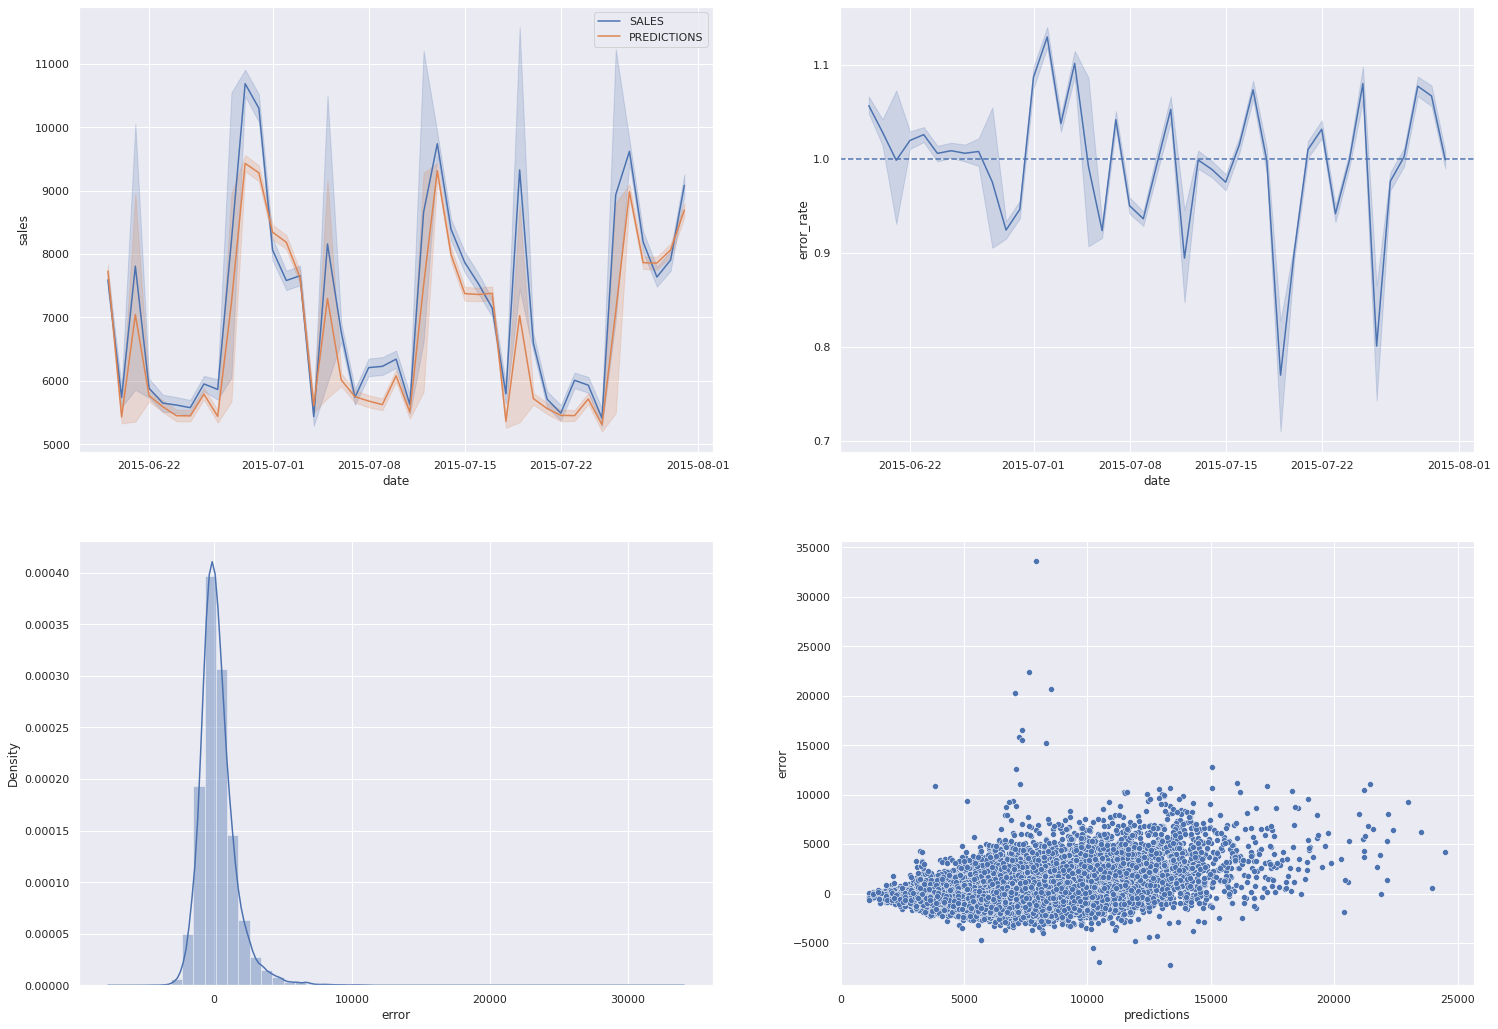

In [94]:
plt.subplot (2,2,1)
sns.lineplot (x = 'date', y = 'sales', data = df9, label = 'SALES')
sns.lineplot (x = 'date', y = 'predictions', data = df9, label = 'PREDICTIONS')

plt.subplot (2,2,2)
sns.lineplot (x = 'date', y = 'error_rate', data = df9)
plt.axhline( 1, linestyle = '--')

plt.subplot (2,2,3)
sns.distplot (df9['error'])

plt.subplot (2,2,4)
sns.scatterplot (df9['predictions'], df9['error'])

# 10.0. DEPLOY MODEL TO PRODUCTION

In [95]:
# Saving final model
pickle.dump (model_xgb_tuned, open ('/home/eron/repos/RossmannProject/model/model_rossmann.pkl', 'wb'))

## 10.1. Rossmann Class

In [141]:
import pickle
import inflection
import math
import datetime
import pandas  as pd
import numpy   as np


class Rossmann( object ):
    
    def __init__( self ):
        self.home_path = '/home/eron/repos/RossmannProject/'
        self.competition_distance_scaler = pickle.load ( open ( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_scaler     = pickle.load ( open ( self.home_path + 'parameter/competition_time_scaler.pkl', 'rb'))
        self.promo_time_week_scaler      = pickle.load ( open ( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                 = pickle.load ( open ( self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler           = pickle.load ( open ( self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))
        
    
    def data_cleaning (self, df1 ):
        
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore (x)

        cols_new = list( map( snakecase, cols_old ))

        #rename
        df1.columns = cols_new

        ## 1.3. Data Types
        df1['date'] = pd.to_datetime(df1['date'])

        ## 1.5. Fillout NA
        #competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan(x) else x)

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

        #competition_open_since_year
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

        #promo2_since_week
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week']) else x['promo2_since_week'], axis=1)

        #promo2_since_year
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year']) else x['promo2_since_year'], axis=1)

        #promo_interval
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Set', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
        df1['promo_interval'].fillna(0, inplace=True)
        df1['month_map'] = df1['date'].dt.month.map(month_map)
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

        ## 1.6. Change Types 
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
        
        return df1
    
    
    def feature_engineering ( self, df2 ):
        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week

        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


        # competition since
        df2['competition_since'] = df2.apply (lambda x: datetime.datetime (year = x['competition_open_since_year'], month = x['competition_open_since_month'] , day = 1), axis = 1)
        df2['competition_time'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta( days = 7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

        # assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'Christmas' if x == 'c' else 'regular_day')

        # 3.0. FILTRAGEM DE VARIÁVEIS
        # Para haver vendas a loja precisa estar aberta
        # Só interessam as vendas maiores que 0, quando for 0 a loja estava fechada
        df2 = df2[df2['open'] != 0]

        # CUSTOMERS - Não há como saber quantos consumidores estarão na loja nos dias das 6 semanas de predição de vendas
        # OPEN - Após a filtragem das linhas feita acima, a coluna open passou a ter apenas valores 1, assim não há variação e informação relevante.
        # PROMO_INTERVAL - Foi derivada e resultou a coluna IS_PROMO, seu conteúdo não é mais relevante.
        # MONTH_MAP - coluna auxiliar usada para a criação das datas, neste momento já não tem mais utilidade.

        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)
        
        return df2
    
   
    def data_preparation (self, df5):
            
        ## 5.2. Rescaling
        # competition_distance - RobustScaler
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values)
        
        # competition_time - RobustScaler
        df5['competition_time'] = self.competition_time_scaler.fit_transform( df5[['competition_time']].values)
        
        # promo_time_week - MinMaxScaler
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values)
        
        # year - MinMaxScaler
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values)

        ## 5.3. Transformação
        ### 5.3.1. Encoding

        # state_holiday - variável que reflete um estado/situação (dia regular ou feriado) - ONE HOT ENCODING
        df5 = pd.get_dummies (df5, prefix = ['state_holiday'], columns = ['state_holiday'])

        # store_type - não há como verificar se existe uma ordem de importância - LABEL ENCODING
        df5 ['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'])

        # assortment - Existe certa hierarquia entre os dados - ORDINAL ENCODING
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        ### 5.3.3. Nature Transformation

        # month - os meses de um ano formam um ciclo de 1 até 12 - TRANSFORMAÇÃO CÍCLICA
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin (x * (2 * np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos (x * (2 * np.pi/12)))

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin (x * (2 * np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos (x * (2 * np.pi/30)))


        # week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin (x * (2 * np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos (x * (2 * np.pi/52)))


        # day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin (x * (2 * np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos (x * (2 * np.pi/7)))
        
        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'promo2', 'promo2_since_week', 
                         'promo2_since_year', 'competition_time', 'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_cos', 'month_sin', 'day_cos', 'day_sin', 'week_of_year_cos',
                         'week_of_year_sin']
        
        return df5 [ cols_selected ]
    
    def get_prediction (self, model, original_data, test_data):
        # prediction
        pred = model.predict ( test_data )
        
        # join pred into the orinal data
        original_data['prediction'] = np.expm1( pred )
    
        return original_data.to_json (orient = 'records', date_format = 'iso')


## 10.2. API Handler

In [129]:
import pickle
import pandas as pd

from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann

# Loading model
model = pickle.load ( open ('/home/eron/repos/RossmannProject/model/model_rossmann.pkl', 'rb'))

# Initialize API
app = Flask ( __name__ )

@app.route ('/rossmann/predict', methods = ['POST'])
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: #there is data
        if isinstance (test_json, dict) : # Unique example
            test_raw = pd.DataFrame( test_json, index = [0])
        else:                             # Multiple example
            test_raw = pd.DataFrame( test_json, columns = test_json[0].keys())
            
        #Instantiate Rossmann Class
        pipeline = Rossmann()
        
        # Data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # Feature engineering
        df2 = pipeline.feature_engineering ( df1 )
        
        # Data perparation
        df3 = pipeline.data_preparation ( df2 )
        
        # Prediction
        df_response = pipeline.get_prediction ( model, test_raw, df3 )
        
        return df_response
    
        
    else:
        return Response( '{}', status = 200, mimetype = 'application/json')

if __name__ == '__main__' :
    app.run( '0.0.0.0', port = 5000, debug = True )

ModuleNotFoundError: No module named 'rossmann'

## 10.3. API Tester

In [1]:
import requests

In [5]:
# Loading test dataset
df10 = pd.read_csv('/home/eron/repos/RossmannProject/data/test.csv')

In [11]:
# Merge test + store
df_test = pd.merge (df10, df_store_raw, how = 'left', on = 'Store')

# Choose store for prediction
df_test = df_test[df_test['Store'].isin( [22, 12] )]

# Remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis = 1)

In [12]:
# Convert DataFrame in Json
data = json.dumps(df_test.to_dict( orient = 'records'))

In [13]:
# API Call
#url = 'http://0.0.0.0:5000/rossmann/predict'
url = 'https://rossmann-model-sales.herokuapp.com/rossmann/predict'
header = {'Content-type' : 'application/json'}
data = data

r = requests.post(url, data = data, headers = header)
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [14]:
d1 = pd.DataFrame (r.json(), columns = r.json()[0].keys())

In [15]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range( len( d2 ) ) :
    print ('Store number {} will sell US$ {:,.2f} in the next 6 weeks'.format (
            d2.loc[i, 'store'],
            d2.loc[i, 'prediction'] ) )

Store number 12 will sell US$ 258,812.07 in the next 6 weeks
Store number 22 will sell US$ 166,455.74 in the next 6 weeks
